In [1]:
import os
import sys
import logging
import time
import json
import random
from enum import Enum
from dataclasses import dataclass, asdict
from typing import Dict, List, Optional, Tuple, Callable
import warnings

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
"""
Deep Hedging Engine pour Produits GMAB
Version complète et optimisée pour la finance de marché
Auteur: Deep Hedging Team
Date: Février 2026
"""



# =================================================================================
# CONFIGURATION TENSORFLOW
# =================================================================================
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = '42'
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Seeds pour reproductibilité
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

# =================================================================================
# CONFIGURATION LOGGING
# =================================================================================
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# =================================================================================
# ENUMS ET DATACLASSES
# =================================================================================
class ModelType(Enum):
    """Types de modèles supportés."""
    FFNN = "FFNN"
    LSTM = "LSTM"
    GRU = "GRU"

@dataclass
class ModelConfig:
    """Configuration du modèle de deep hedging."""
    model_type: ModelType = ModelType.LSTM
    n_assets: int = 6  # S + 5 ZC
    n_features: int = 11  # 10 market features + 1 portfolio value
    hidden_layers: int = 2
    units: int = 64
    learning_rate: float = 0.001
    alpha_cvar: float = 0.99
    lambda_cost: float = 0.001
    scale_factor_zc: float = 5.0
    dropout_rate: float = 0.2
    recurrent_dropout: float = 0.1
    batch_normalization: bool = True
    gradient_clip_norm: float = 1.0
    l2_regularization: float = 1e-3
    
    def to_dict(self) -> Dict:
        """Convertit la config en dictionnaire."""
        return {
            'model_type': self.model_type.value,
            **{k: v for k, v in asdict(self).items() if k != 'model_type'}
        }
    
    @classmethod
    def from_dict(cls, config_dict: Dict) -> 'ModelConfig':
        """Crée une config depuis un dictionnaire."""
        config_dict = config_dict.copy()
        if 'model_type' in config_dict:
            config_dict['model_type'] = ModelType(config_dict['model_type'])
        return cls(**config_dict)

# =================================================================================
# CLASSES UTILITAIRES
# =================================================================================
class DataNormalizer:
    """Normaliseur de données avec sauvegarde des paramètres."""
    
    def __init__(self, epsilon: float = 1e-8, method: str = 'standard'):
        """
        Args:
            epsilon: Petite valeur pour éviter division par zéro
            method: 'standard' (z-score) ou 'minmax'
        """
        self.mean = None
        self.std = None
        self.min_val = None
        self.max_val = None
        self.epsilon = epsilon
        self.method = method
        self.is_fitted = False
    
    def fit(self, data: np.ndarray) -> 'DataNormalizer':
        """Calcule les statistiques de normalisation."""
        if data.ndim != 3:
            raise ValueError(f"Data doit avoir 3 dimensions (B, T, D), reçu {data.ndim}")
        
        if self.method == 'standard':
            self.mean = np.mean(data, axis=(0, 1))
            self.std = np.std(data, axis=(0, 1)) + self.epsilon
        elif self.method == 'minmax':
            self.min_val = np.min(data, axis=(0, 1))
            self.max_val = np.max(data, axis=(0, 1))
        else:
            raise ValueError(f"Méthode inconnue: {self.method}")
        
        self.is_fitted = True
        logger.info(f"Normalizer fitted - method: {self.method}")
        return self
    
    def transform(self, data: np.ndarray) -> np.ndarray:
        """Normalise les données."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before transform")
        
        if self.method == 'standard':
            return (data - self.mean) / self.std
        else:  # minmax
            return (data - self.min_val) / (self.max_val - self.min_val + self.epsilon)
    
    def inverse_transform(self, data: np.ndarray) -> np.ndarray:
        """Dés-normalise les données."""
        if not self.is_fitted:
            raise RuntimeError("Normalizer must be fitted before inverse_transform")
        
        if self.method == 'standard':
            return data * self.std + self.mean
        else:  # minmax
            return data * (self.max_val - self.min_val + self.epsilon) + self.min_val
    
    def fit_transform(self, data: np.ndarray) -> np.ndarray:
        """Fit et transform en une seule étape."""
        return self.fit(data).transform(data)
    
    def save(self, path: str) -> None:
        """Sauvegarde le normaliseur."""
        if not self.is_fitted:
            raise RuntimeError("Cannot save unfitted normalizer")
        
        save_dict = {
            'epsilon': self.epsilon,
            'method': self.method
        }
        
        if self.method == 'standard':
            save_dict['mean'] = self.mean
            save_dict['std'] = self.std
        else:
            save_dict['min_val'] = self.min_val
            save_dict['max_val'] = self.max_val
        
        np.savez(path, **save_dict)
        logger.info(f"Normalizer sauvegardé dans {path}")
    
    @classmethod
    def load(cls, path: str) -> 'DataNormalizer':
        """Charge un normaliseur sauvegardé."""
        data = np.load(path, allow_pickle=True)
        method = str(data['method'])
        epsilon = float(data['epsilon'])
        
        normalizer = cls(epsilon=epsilon, method=method)
        
        if method == 'standard':
            normalizer.mean = data['mean']
            normalizer.std = data['std']
        else:
            normalizer.min_val = data['min_val']
            normalizer.max_val = data['max_val']
        
        normalizer.is_fitted = True
        logger.info(f"Normalizer chargé depuis {path}")
        return normalizer


class EarlyStopping:
    """Implémentation améliorée d'early stopping."""
    
    def __init__(self, 
                 patience: int = 10, 
                 min_delta: float = 0.0, 
                 restore_best_weights: bool = True,
                 mode: str = 'min'):
        """
        Args:
            patience: Nombre d'époques sans amélioration avant arrêt
            min_delta: Amélioration minimale pour compter comme progrès
            restore_best_weights: Si True, restaure les meilleurs poids
            mode: 'min' pour minimiser, 'max' pour maximiser
        """
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.mode = mode
        self.best_loss = float('inf') if mode == 'min' else float('-inf')
        self.wait = 0
        self.best_weights = None
        self.stopped_epoch = 0
        self.best_epoch = 0
    
    def _is_improvement(self, current_loss: float) -> bool:
        """Vérifie si la perte actuelle est une amélioration."""
        if self.mode == 'min':
            return current_loss < self.best_loss - self.min_delta
        else:
            return current_loss > self.best_loss + self.min_delta
    
    def __call__(self, current_loss: float, model: keras.Model, epoch: int = 0) -> bool:
        """
        Vérifie si l'entraînement doit s'arrêter.
        
        Returns:
            True si l'entraînement doit s'arrêter, False sinon
        """
        if self._is_improvement(current_loss):
            self.best_loss = current_loss
            self.wait = 0
            self.best_epoch = epoch
            if self.restore_best_weights:
                self.best_weights = model.get_weights()
            return False
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                if self.restore_best_weights and self.best_weights is not None:
                    logger.info(f"Restauration des poids de l'époque {self.best_epoch}")
                    model.set_weights(self.best_weights)
                return True
            return False
    
    def get_best_info(self) -> Dict:
        """Retourne les informations sur le meilleur modèle."""
        return {
            'best_loss': self.best_loss,
            'best_epoch': self.best_epoch,
            'stopped_epoch': self.stopped_epoch
        }

# =================================================================================
# FONCTIONS DE PERTE
# =================================================================================
def entropic_risk_loss(lam: float = 0.1):
    """
    Entropic risk measure avec stabilité numérique améliorée.
    
    Args:
        lam: Paramètre d'aversion au risque (plus élevé = plus conservateur)
    
    Returns:
        Fonction de perte TensorFlow
    """
    @tf.function
    def loss(y_true, PnL):
        # Ne considérer que les pertes (PnL > 0)
        losses = tf.maximum(PnL, 0.0)
        
        # Stabilisation numérique
        max_loss = tf.reduce_max(losses)
        exp_term = tf.exp(lam * (losses - max_loss))
        mean_exp = tf.reduce_mean(exp_term)
        
        # Éviter log(0)
        log_term = tf.math.log(mean_exp + 1e-8)
        
        return (1.0 / (lam + 1e-8)) * (log_term + max_loss)
    
    return loss


def cvar_loss(alpha: float = 0.99):
    """
    Conditional Value at Risk (CVaR) loss.
    
    Args:
        alpha: Niveau de quantile (0.90-0.999)
    
    Returns:
        Fonction de perte TensorFlow
    """
    @tf.function
    def loss(y_true, PnL):
        # Calculer le VaR (quantile)
        sorted_pnl = tf.sort(PnL, direction='ASCENDING')
        n = tf.shape(sorted_pnl)[0]
        var_idx = tf.cast(tf.cast(n, tf.float32) * alpha, tf.int32)
        var = sorted_pnl[var_idx]
        
        # CVaR = moyenne des pertes au-delà du VaR
        excess = tf.maximum(PnL - var, 0.0)
        cvar = var + tf.reduce_mean(excess) / (1.0 - alpha + 1e-8)
        
        return cvar
    
    return loss

# =================================================================================
# CLASSE PRINCIPALE
# =================================================================================
class DeepHedgingEngine:
    """
    Moteur de deep hedging optimisé pour produits GMAB.
    Version améliorée pour la finance de marché.
    """
    
    def __init__(self, config: ModelConfig):
        """Initialisation avec validation des paramètres."""
        try:
            self._validate_config(config)
            self.config = config
            self.model = None
            self.normalizer = DataNormalizer(method='standard')
            self.early_stopping = None
            self.training_history = {
                'train_loss': [],
                'val_loss': [],
                'learning_rates': [],
                'epoch_times': []
            }
            logger.info(f"✓ DeepHedgingEngine initialisé - {config.model_type.value}")
        except Exception as e:
            logger.error(f"✗ Erreur d'initialisation: {str(e)}")
            raise
    
    def _validate_config(self, config: ModelConfig) -> None:
        """Valide la configuration avec messages détaillés."""
        validations = [
            (config.n_assets > 0, f"n_assets doit être > 0, reçu {config.n_assets}"),
            (config.n_features > 0, f"n_features doit être > 0, reçu {config.n_features}"),
            (config.hidden_layers > 0, f"hidden_layers doit être > 0, reçu {config.hidden_layers}"),
            (config.units > 0, f"units doit être > 0, reçu {config.units}"),
            (0 < config.learning_rate < 1, f"learning_rate doit être entre 0 et 1, reçu {config.learning_rate}"),
            (0 < config.alpha_cvar < 1, f"alpha_cvar doit être entre 0 et 1, reçu {config.alpha_cvar}"),
            (config.lambda_cost >= 0, f"lambda_cost doit être >= 0, reçu {config.lambda_cost}"),
            (0 <= config.dropout_rate < 1, f"dropout_rate doit être entre 0 et 1, reçu {config.dropout_rate}"),
        ]
        
        for condition, message in validations:
            if not condition:
                raise ValueError(message)
    
    def _build_model(self) -> keras.Model:
        """Construit le modèle de réseau neuronal."""
        logger.info(f"🔨 Construction du modèle {self.config.model_type.value}")
        
        inputs = layers.Input(shape=(None, self.config.n_features), name='market_inputs')
        x = inputs
        
        # Batch Normalization initiale (optionnel)
        if self.config.batch_normalization:
            x = layers.TimeDistributed(layers.BatchNormalization())(x)
        
        # Architecture selon le type
        if self.config.model_type == ModelType.FFNN:
            x = self._build_ffnn(x)
        elif self.config.model_type == ModelType.LSTM:
            x = self._build_lstm(x)
        elif self.config.model_type == ModelType.GRU:
            x = self._build_gru(x)
        else:
            raise ValueError(f"Type de modèle non supporté: {self.config.model_type}")
        
        # Couche de sortie
        outputs = layers.TimeDistributed(
            layers.Dense(
                self.config.n_assets,
                activation='tanh',
                kernel_initializer='glorot_uniform',
                name='hedging_positions'
            )
        )(x)
        
        model = keras.Model(
            inputs=inputs, 
            outputs=outputs, 
            name=f'DeepHedging_{self.config.model_type.value}'
        )
        
        logger.info(f"✓ Modèle construit - Paramètres: {model.count_params():,}")
        
        return model
    
    def _build_ffnn(self, x):
        """Construit architecture FFNN."""
        for i in range(self.config.hidden_layers):
            units = self.config.units // (2**i) if i > 0 else self.config.units
            
            x = layers.TimeDistributed(
                layers.Dense(
                    units=units,
                    activation='relu',
                    kernel_initializer='he_normal',
                    kernel_regularizer=keras.regularizers.l2(self.config.l2_regularization)
                )
            )(x)
            
            if self.config.batch_normalization:
                x = layers.TimeDistributed(layers.BatchNormalization())(x)
            
            if i == self.config.hidden_layers - 1 and self.config.dropout_rate > 0:
                x = layers.Dropout(self.config.dropout_rate)(x)
        
        return x
    
    def _build_lstm(self, x):
        """Construit architecture LSTM."""
        for i in range(self.config.hidden_layers):
            units = self.config.units // (2**i) if i > 0 else self.config.units
            
            x = layers.LSTM(
                units,
                return_sequences=True,
                dropout=self.config.dropout_rate if i == self.config.hidden_layers - 1 else 0.0,
                recurrent_dropout=self.config.recurrent_dropout if i == self.config.hidden_layers - 1 else 0.0,
                kernel_regularizer=keras.regularizers.l2(self.config.l2_regularization),
                recurrent_regularizer=keras.regularizers.l2(self.config.l2_regularization)
            )(x)
            
            if self.config.batch_normalization:
                x = layers.BatchNormalization()(x)
        
        return x
    
    def _build_gru(self, x):
        """Construit architecture GRU."""
        for i in range(self.config.hidden_layers):
            units = self.config.units // (2**i) if i > 0 else self.config.units
            
            x = layers.GRU(
                units,
                return_sequences=True,
                dropout=self.config.dropout_rate if i == self.config.hidden_layers - 1 else 0.0,
                recurrent_dropout=self.config.recurrent_dropout if i == self.config.hidden_layers - 1 else 0.0,
                kernel_regularizer=keras.regularizers.l2(self.config.l2_regularization),
                recurrent_regularizer=keras.regularizers.l2(self.config.l2_regularization)
            )(x)
            
            if self.config.batch_normalization:
                x = layers.BatchNormalization()(x)
        
        return x
    
    def compile_model(self, model: keras.Model, loss_fn: Optional[Callable] = None):
        """Compile le modèle avec configuration optimisée."""
        if loss_fn is None:
            loss_fn = cvar_loss(alpha=self.config.alpha_cvar)
        
        # Learning rate schedule
        lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=self.config.learning_rate,
            decay_steps=1000,
            decay_rate=0.9
        )
        
        # Optimiseur avec gradient clipping
        optimizer = keras.optimizers.Adam(
            learning_rate=lr_schedule,
            clipnorm=self.config.gradient_clip_norm
        )
        
        model.compile(optimizer=optimizer, loss=loss_fn)
        logger.info("✓ Modèle compilé")
    
    @tf.function
    def _simulate_one_step(self,
                          V_t: tf.Tensor,
                          delta_pred: tf.Tensor,
                          delta_t: tf.Tensor,
                          inputs_t: tf.Tensor,
                          inputs_tp1: tf.Tensor,
                          r_t: tf.Tensor,
                          dt: float,
                          n_step: tf.Tensor = None) -> tf.Tensor:
        """
        Simule UN SEUL pas de temps du portefeuille auto-financé.
        Optimisé pour la finance de marché.
        """
        lambda_cost = self.config.lambda_cost
        scale_factor_zc = self.config.scale_factor_zc
        maturities_months = tf.constant([12, 60, 180, 240, 300], dtype=tf.int32)
        if n_step is None:
            n_step = tf.constant(0, dtype=tf.int32)
        B = tf.shape(V_t)[0]
        
        # Extraction des actifs (déjà en log dans inputs)
        log_assets_t = inputs_t[:, :6]
        assets_real_t = tf.exp(log_assets_t)
        swaps_real_t = inputs_t[:, 6:7]  # Swap rate asset
        assets_real_t = tf.concat([assets_real_t, swaps_real_t], axis=1)

        log_assets_tp1 = inputs_tp1[:, :6]
        assets_real_tp1 = tf.exp(log_assets_tp1)
        swaps_real_tp1 = inputs_tp1[:, 6:7]  # Swap rate asset
        assets_real_tp1 = tf.concat([assets_real_tp1, swaps_real_tp1], axis=1)

        # Scaling des positions
        scale_mask = tf.concat([
            tf.ones((1,), dtype=tf.float32),  # Action
            tf.ones((5,), dtype=tf.float32) * scale_factor_zc,  # 5 ZC
            tf.ones((1,), dtype=tf.float32) * 100  # Swap rate asset
        ], axis=0)
        
        delta_scaled = delta_t * scale_mask
        delta_scaled_prev = delta_pred * scale_mask

        # Gestion du roulement (optionnel, ici simplifié)
        cash_flow_roll = tf.zeros((B,), dtype=tf.float32)
        for i in range(5):
            is_expiry = tf.equal(n_step + 1, maturities_months[i])
            if tf.reduce_any(is_expiry):
                sell_price = 1.0
                buy_price = assets_real_tp1[:, i + 1]
                roll_cf = (sell_price - buy_price) * delta_scaled_prev[:, i + 1]
                cash_flow_roll += tf.where(is_expiry, roll_cf, 0.0)

        
        # Coûts de transaction proportionnels
        delta_change = tf.abs(delta_scaled - delta_scaled_prev)
        transaction_costs = lambda_cost * tf.reduce_sum(delta_change * assets_real_t, axis=1)
        
        # Gains/pertes de marché
        exp_r_dt = tf.exp(r_t * dt)
        exp_r_dt_ext = tf.expand_dims(exp_r_dt, axis=1)
        
        price_changes = assets_real_tp1 - exp_r_dt_ext * assets_real_t
        market_pnl = tf.reduce_sum(delta_scaled * price_changes, axis=1)
        
        # Actualisation du cash
        cash_growth = exp_r_dt * V_t
        
        # Mise à jour totale
        V_next = cash_growth + market_pnl - transaction_costs + cash_flow_roll
        
        return V_next
    
    def create_dataset(self,
                      inputs: np.ndarray,
                      H: np.ndarray,
                      r: np.ndarray,
                      batch_size: int = 512,
                      shuffle: bool = True) -> tf.data.Dataset:
        """Crée un dataset TensorFlow optimisé."""
        dataset = tf.data.Dataset.from_tensor_slices((inputs, H, r))
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=10000, seed=42)
        
        dataset = dataset.batch(batch_size, drop_remainder=False)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        
        return dataset
    
    def train(self,
              train_input: np.ndarray,
              train_input_norm: np.ndarray,
              H_train: np.ndarray,
              r_train: np.ndarray,
              V0_train: float,
              V0_valid: float,
              dt: float,
              val_input: Optional[np.ndarray] = None,
              val_input_norm: Optional[np.ndarray] = None,
              H_val: Optional[np.ndarray] = None,
              r_val: Optional[np.ndarray] = None,
              epochs: int = 50,
              batch_size: int = 1024,
              patience: int = 10,
              loss_fn: Optional[Callable] = None,
              verbose: int = 1) -> Dict[str, list]:
        """
        Entraînement amélioré avec validation et early stopping.
        """
        logger.info("=" * 80)
        logger.info("🚀 DÉBUT DE L'ENTRAÎNEMENT")
        logger.info("=" * 80)
        
        # Construction et compilation du modèle
        if self.model is None:
            self.model = self._build_model()
            self.compile_model(self.model, loss_fn=loss_fn)
        
        # Configuration early stopping
        self.early_stopping = EarlyStopping(
            patience=patience,
            min_delta=0.001,
            restore_best_weights=True,
            mode='min'
        )
        
        # Création des datasets
        train_dataset_model = self.create_dataset(
            train_input_norm, H_train, r_train, batch_size, shuffle=False
        )
        train_dataset_sim = self.create_dataset(
            train_input, H_train, r_train, batch_size, shuffle=False
        )
        train_dataset = tf.data.Dataset.zip((train_dataset_model, train_dataset_sim))
        
        # Validation
        validation_enabled = all([
            val_input is not None,
            val_input_norm is not None,
            H_val is not None,
            r_val is not None
        ])
        
        if validation_enabled:
            val_dataset_model = self.create_dataset(
                val_input_norm, H_val, r_val, batch_size, shuffle=False
            )
            val_dataset_sim = self.create_dataset(
                val_input, H_val, r_val, batch_size, shuffle=False
            )
            val_dataset = tf.data.Dataset.zip((val_dataset_model, val_dataset_sim))
            logger.info("✓ Validation activée")
        else:
            val_dataset = None
            logger.warning("⚠ Validation désactivée")
        
        # Boucle d'entraînement
        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            # === PHASE D'ENTRAÎNEMENT ===
            train_losses = []
            for batch_model, batch_sim in train_dataset:
                batch_input_norm, batch_H, batch_r = batch_model
                batch_input_raw, _, _ = batch_sim
                
                B = tf.shape(batch_input_raw)[0]
                T = tf.shape(batch_input_raw)[1] - 1
                
                with tf.GradientTape() as tape:
                    V_t = tf.ones((B,), dtype=tf.float32) * V0_train
                    delta_pred = tf.zeros((B, self.config.n_assets), dtype=tf.float32)
                    for t in range(T):
                        # Input avec valeur portefeuille normalisée
                        current_market = batch_input_norm[:, t, :]
                        current_input = tf.concat([
                            current_market,
                            tf.expand_dims(V_t / V0_train, axis=1)
                        ], axis=1)
                        
                        # Prédire positions
                        delta_t = self.model(
                            tf.expand_dims(current_input, axis=1),
                            training=True
                        )
                        delta_t = tf.squeeze(delta_t, axis=1)
                        
                        # Simuler un pas
                        V_t = self._simulate_one_step(
                            V_t, delta_pred, delta_t,
                            batch_input_raw[:, t, :],
                            batch_input_raw[:, t + 1, :],
                            batch_r[:, t], dt
                        )
                        delta_pred = delta_t
                    # Calcul de la perte
                    PnL = batch_H - V_t
                    Pnl_clipped= tf.clip_by_value(PnL, -1e4, 1e4)
                    total_loss = self.model.loss(None, tf.expand_dims(Pnl_clipped, axis=1))
                
                # Mise à jour des poids
                grads = tape.gradient(total_loss, self.model.trainable_variables)
                self.model.optimizer.apply_gradients(
                    zip(grads, self.model.trainable_variables)
                )
                
                train_losses.append(total_loss.numpy())
            
            avg_train_loss = np.mean(train_losses)
            self.training_history['train_loss'].append(float(avg_train_loss))
            
            # === PHASE DE VALIDATION ===
            avg_val_loss = None
            if validation_enabled:
                val_losses = []
                for batch_model, batch_sim in val_dataset:
                    batch_input_norm, batch_H, batch_r = batch_model
                    batch_input_raw, _, _ = batch_sim
                    
                    B = tf.shape(batch_input_norm)[0]
                    T = tf.shape(batch_input_norm)[1] - 1
                    
                    V_t = tf.ones((B,), dtype=tf.float32) * V0_valid
                    delta_pred = tf.zeros((B, self.config.n_assets), dtype=tf.float32)
                    
                    for t in range(T):
                        current_market = batch_input_norm[:, t, :]
                        current_input = tf.concat([
                            current_market,
                            tf.expand_dims(V_t / V0_valid, axis=1)
                        ], axis=1)
                        
                        delta_t = self.model(
                            tf.expand_dims(current_input, axis=1),
                            training=False
                        )
                        delta_t = tf.squeeze(delta_t, axis=1)
                        
                        V_t = self._simulate_one_step(
                            V_t, delta_pred, delta_t,
                            batch_input_raw[:, t, :],
                            batch_input_raw[:, t + 1, :],
                            batch_r[:, t], dt
                        )
                        delta_pred = delta_t
                    
                    PnL = batch_H - V_t
                    Pnl_clipped= tf.clip_by_value(PnL, -1e4, 1e4)
                    

                    total_loss = self.model.loss(None, tf.expand_dims(Pnl_clipped, axis=1))
                    val_losses.append(total_loss.numpy())
                
                avg_val_loss = np.mean(val_losses)
                self.training_history['val_loss'].append(float(avg_val_loss))
                
                # Early stopping
                if self.early_stopping(avg_val_loss, self.model, epoch):
                    logger.info(f"🛑 Early stopping à l'époque {epoch + 1}")
                    break
            
            # === LOGGING ===
            epoch_time = time.time() - epoch_start_time
            self.training_history['epoch_times'].append(float(epoch_time))
            
            try:
                lr = float(self.model.optimizer.learning_rate(
                    self.model.optimizer.iterations
                ))
            except:
                lr = float(self.model.optimizer.learning_rate)
            
            self.training_history['learning_rates'].append(lr)
            
            if verbose > 0 and ((epoch + 1) % max(1, epochs // 20) == 0 or epoch == 0):
                log_msg = f"📊 Epoch {epoch + 1:3d}/{epochs} │ "
                log_msg += f"Train: {avg_train_loss:.4f} │ "
                if avg_val_loss is not None:
                    log_msg += f"Val: {avg_val_loss:.4f} │ "
                log_msg += f"LR: {lr:.2e} │ "
                log_msg += f"⏱ {epoch_time:.1f}s"
                logger.info(log_msg)
        
        # Résumé final
        logger.info("=" * 80)
        logger.info("✅ ENTRAÎNEMENT TERMINÉ")
        if validation_enabled:
            best_info = self.early_stopping.get_best_info()
            logger.info(f"   Meilleure val loss: {best_info['best_loss']:.4f}")
            logger.info(f"   Meilleure époque: {best_info['best_epoch']}")
        total_time = sum(self.training_history['epoch_times'])
        logger.info(f"   Temps total: {total_time:.1f}s ({total_time/60:.1f}min)")
        logger.info("=" * 80)
        
        return self.training_history
    
    def predict(self,
                test_input: np.ndarray,
                test_input_norm: np.ndarray,
                r_test: np.ndarray,
                dt: float,
                V0: float,
                return_trajectory: bool = False) -> Tuple:
        """Prédiction avec le modèle entraîné."""
        if self.model is None:
            raise RuntimeError("Le modèle doit être entraîné avant la prédiction")
        
        logger.info("🔮 Génération des prédictions...")
        
        B = test_input.shape[0]
        T = test_input.shape[1] - 1
        
        # Convertir en tenseurs
        test_input_tf = tf.constant(test_input, dtype=tf.float32)
        test_input_norm_tf = tf.constant(test_input_norm, dtype=tf.float32)
        r_test_tf = tf.constant(r_test, dtype=tf.float32)
        
        V_t = tf.ones((B,), dtype=tf.float32) * V0
        delta_prev = tf.zeros((B, self.config.n_assets), dtype=tf.float32)
        
        all_deltas = []
        V_trajectory = [V_t.numpy()] if return_trajectory else None
        print(T)
        for t in range(T):
            # Préparer input
            current_input = tf.concat([
                test_input_norm_tf[:, t, :],
                tf.expand_dims(V_t / V0, axis=1)
            ], axis=1)
            
            # Prédire positions
            delta_t = self.model(
                tf.expand_dims(current_input, axis=1),
                training=False
            )
            delta_t = tf.squeeze(delta_t, axis=1)
            all_deltas.append(delta_t)
            
            # Simuler un pas
            V_t = self._simulate_one_step(
                V_t, delta_prev, delta_t,
                test_input_tf[:, t, :],
                test_input_tf[:, t + 1, :],
                r_test_tf[:, t], dt
            )
            
            if return_trajectory:
                V_trajectory.append(V_t.numpy())
            
            delta_prev = delta_t
        
        V_T = V_t.numpy()
        delta_pred = tf.stack(all_deltas, axis=1).numpy()
        
        logger.info("✓ Prédictions générées")
        
        if return_trajectory:
            V_trajectory = np.array(V_trajectory).T
            return V_T, delta_pred, V_trajectory
        
        return V_T, delta_pred
    
    def evaluate(self,
                 test_input: np.ndarray,
                 test_input_norm: np.ndarray,
                 H_test: np.ndarray,
                 r_test: np.ndarray,
                 dt: float,
                 V0: float,
                 detailed: bool = True) -> Dict[str, float]:
        """Évaluation complète du modèle."""
        logger.info("📊 Évaluation du modèle...")
        
        V_T, delta_pred, V_trajectory = self.predict(
            test_input, test_input_norm, r_test, dt, V0, return_trajectory=True
        )
        
        PnL = H_test - V_T
        # Filtrer les outliers extrêmes pour l'affichage
        #mask = np.abs(PnL) < 1e4
        PnL_filtered = PnL #[mask]
        # Métriques de base
        results = {
            'mean_pnl': float(np.mean(PnL_filtered)),
            'std_pnl': float(np.std(PnL_filtered)),
            'min_pnl': float(np.min(PnL_filtered)),
            'max_pnl': float(np.max(PnL_filtered)),
            'median_pnl': float(np.median(PnL_filtered)),
        }
        
        # Métriques de risque
        for alpha in [0.90, 0.95, 0.99]:
            var = np.percentile(PnL_filtered, alpha * 100)
            cvar = np.mean(PnL_filtered[PnL_filtered >= var])
            results[f'var_{int(alpha * 100)}'] = float(var)
            results[f'cvar_{int(alpha * 100)}'] = float(cvar)
        
        # Métriques avancées
        if detailed:
            results['skewness'] = float(stats.skew(PnL_filtered))
            results['kurtosis'] = float(stats.kurtosis(PnL_filtered))
            results['sharpe_ratio'] = float(np.mean(PnL_filtered) / (np.std(PnL_filtered) + 1e-8))
            
            # Efficacité de la couverture
            hedge_efficiency = 1 - (np.std(PnL_filtered) / (np.std(H_test) + 1e-8))
            results['efficiency'] = float(hedge_efficiency)
            
            # Taux de succès (PnL < 0)
            success_rate = np.mean(PnL_filtered < 0)
            results['success_rate'] = float(success_rate)
        
        # Affichage des résultats
        logger.info("\n" + "=" * 80)
        logger.info("📈 RÉSULTATS D'ÉVALUATION")
        logger.info("=" * 80)
        
        for key, value in results.items():
            logger.info(f"  {key:.<30} {value:>15.4f}")
        
        logger.info("=" * 80 + "\n")
        
        return results,V_T, delta_pred, V_trajectory,PnL_filtered
    
    def save(self, path: str) -> None:
        """Sauvegarde complète du modèle."""
        os.makedirs(path, exist_ok=True)
        
        logger.info(f"💾 Sauvegarde du modèle dans {path}")
        
        # Sauvegarder les poids
        model_path = os.path.join(path, "model.weights.h5")
        self.model.save_weights(model_path)
        
        # Sauvegarder la configuration
        config_path = os.path.join(path, "config.json")
        with open(config_path, 'w') as f:
            json.dump(self.config.to_dict(), f, indent=2)
        
        # Sauvegarder l'historique
        history_path = os.path.join(path, "training_history.json")
        with open(history_path, 'w') as f:
            json.dump(self.training_history, f, indent=2)
        
        # Sauvegarder le normaliseur
        if self.normalizer.is_fitted:
            normalizer_path = os.path.join(path, "normalizer.npz")
            self.normalizer.save(normalizer_path)
        
        logger.info(f"✓ Modèle sauvegardé avec succès")
    
    @classmethod
    def load(cls, path: str) -> 'DeepHedgingEngine':
        """Charge un modèle sauvegardé."""
        logger.info(f"📂 Chargement du modèle depuis {path}")
        
        # Charger la configuration
        config_path = os.path.join(path, "config.json")
        with open(config_path, 'r') as f:
            config_dict = json.load(f)
        
        config = ModelConfig.from_dict(config_dict)
        
        # Créer l'instance
        engine = cls(config)
        engine.model = engine._build_model()
        
        # Charger les poids
        model_path = os.path.join(path, "model.weights.h5")
        engine.model.load_weights(model_path)
        
        # Charger l'historique
        history_path = os.path.join(path, "training_history.json")
        if os.path.exists(history_path):
            with open(history_path, 'r') as f:
                engine.training_history = json.load(f)
        
        # Charger le normaliseur
        normalizer_path = os.path.join(path, "normalizer.npz")
        if os.path.exists(normalizer_path):
            engine.normalizer = DataNormalizer.load(normalizer_path)
        
        logger.info(f"✓ Modèle chargé avec succès")
        return engine

# =================================================================================
# FONCTIONS UTILITAIRES
# =================================================================================
def compute_metrics(PnL: np.ndarray, alpha: float = 0.99) -> Tuple[float, float, float]:
    """Calcule les métriques de risque."""
    mean = np.mean(PnL)
    var = np.percentile(PnL, alpha * 100)
    cvar = np.mean(PnL[PnL >= var])
    return mean, var, cvar


def roll_zc_paths(P_paths: np.ndarray,
                  maturities: list,
                  N_per_year: int = 12) -> np.ndarray:
    """Roule les zéro-coupons expirés."""
    M, T_plus1, n_zc = P_paths.shape
    P_paths_rolled = P_paths.copy()
    
    for i, maturity in enumerate(maturities):
        expiry_step = int(maturity * N_per_year)
        
        for m in range(M):
            t = expiry_step
            while t < T_plus1:
                next_expiry = t + expiry_step
                if next_expiry >= T_plus1:
                    break
                
                steps_to_copy = min(expiry_step, T_plus1 - t)
                P_paths_rolled[m, t:t + steps_to_copy, i] = P_paths[m, :steps_to_copy, i]
                t = next_expiry
    
    return P_paths_rolled


def compute_realized_volatility(S_paths: np.ndarray, window: int = 20) -> np.ndarray:
    """
    Calcule la volatilité réalisée sur une fenêtre glissante.
    
    Args:
        S_paths: (M, T+1) trajectoires de l'indice
        window: nombre de pas pour la fenêtre
    
    Returns:
        sigma_realized: (M, T+1) volatilité réalisée
    """
    M, T_plus1 = S_paths.shape
    log_returns = np.log(S_paths[:, 1:] / S_paths[:, :-1])
    
    sigma_realized = np.zeros((M, T_plus1), dtype=np.float32)
    
    for t in range(T_plus1):
        if t == 0:
            sigma_realized[:, t] = np.std(log_returns[:, :1], axis=1) + 1e-6
        else:
            start = max(0, t - window)
            end = t
            if end > start:
                sigma_realized[:, t] = np.std(log_returns[:, start:end], axis=1) + 1e-6
            else:
                sigma_realized[:, t] = sigma_realized[:, t - 1]
    
    return sigma_realized


def plot_training_history(history: Dict[str, list],
                          save_path: Optional[str] = None,
                          show: bool = True) -> None:
    """Visualise l'historique d'entraînement."""
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("colorblind")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Historique d\'entraînement', fontsize=16, fontweight='bold')
    
    epochs = np.arange(1, len(history['train_loss']) + 1)
    
    # 1. Loss curves
    ax = axes[0, 0]
    ax.plot(epochs, history['train_loss'], label='Train', linewidth=2)
    if 'val_loss' in history and len(history['val_loss']) > 0:
        ax.plot(epochs, history['val_loss'], label='Validation', linewidth=2)
    ax.set_xlabel('Époque')
    ax.set_ylabel('Perte')
    ax.set_title('Fonction de perte')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Learning rate
    ax = axes[0, 1]
    if 'learning_rates' in history and len(history['learning_rates']) > 0:
        ax.plot(epochs, history['learning_rates'], color='green', linewidth=2)
        ax.set_yscale('log')
        ax.set_xlabel('Époque')
        ax.set_ylabel('Learning Rate (log)')
        ax.set_title('Taux d\'apprentissage')
        ax.grid(True, alpha=0.3)
    
    # 3. Temps par époque
    ax = axes[1, 0]
    if 'epoch_times' in history and len(history['epoch_times']) > 0:
        ax.plot(epochs, history['epoch_times'], color='purple', linewidth=2)
        ax.axhline(np.mean(history['epoch_times']), color='red', linestyle='--',
                  label=f'Moyenne: {np.mean(history["epoch_times"]):.2f}s')
        ax.set_xlabel('Époque')
        ax.set_ylabel('Temps (s)')
        ax.set_title('Temps par époque')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # 4. Différence Train/Val
    ax = axes[1, 1]
    if ('val_loss' in history and len(history['val_loss']) > 0 and
        len(history['train_loss']) == len(history['val_loss'])):
        diff = np.array(history['train_loss']) - np.array(history['val_loss'])
        ax.plot(epochs, diff, color='orange', linewidth=2)
        ax.axhline(0, color='black', linestyle='--', alpha=0.5)
        ax.fill_between(epochs, diff, 0, where=(diff > 0), alpha=0.3, color='red')
        ax.fill_between(epochs, diff, 0, where=(diff <= 0), alpha=0.3, color='green')
        ax.set_xlabel('Époque')
        ax.set_ylabel('Train - Val')
        ax.set_title('Surapprentissage')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"✓ Graphique sauvegardé: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()


def plot_detailed_results(PnL_test: np.ndarray,
                          delta_test: np.ndarray,
                          L_t: np.ndarray,
                          V_test: np.ndarray,
                          T_years: float = 25,
                          save_path: Optional[str] = None,
                          show: bool = True) -> None:
    """Visualisations détaillées."""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    fig.suptitle('Analyse détaillée de la couverture', fontsize=16, fontweight='bold')
    
    t_full = np.linspace(0, T_years, L_t.shape[1] if L_t.ndim == 2 else len(L_t))
    t_hedge = np.linspace(0, T_years, delta_test.shape[1])
    
    # 1. Distribution P&L
    ax = axes[0, 0]
    ax.hist(PnL_test, bins=50, density=True, alpha=0.7, edgecolor='black')
    sns.kdeplot(PnL_test, ax=ax, color='darkblue', linewidth=2)
    ax.axvline(np.mean(PnL_test), color='red', linestyle='--', linewidth=2,
              label=f'Moyenne: {np.mean(PnL_test):.2f}')
    ax.axvline(0, color='green', linestyle='--', linewidth=2)
    ax.set_xlabel('P&L')
    ax.set_ylabel('Densité')
    ax.set_title('Distribution du P&L')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. QQ-Plot
    stats.probplot(PnL_test, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('QQ-Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Passif
    ax = axes[0, 2]
    if L_t.ndim == 2:
        L_mean = np.mean(L_t, axis=0)
        L_5 = np.percentile(L_t, 5, axis=0)
        L_95 = np.percentile(L_t, 95, axis=0)
        ax.plot(t_full, L_mean, color='darkred', linewidth=2, label='Moyenne')
        ax.fill_between(t_full, L_5, L_95, color='red', alpha=0.2)
    else:
        ax.plot(t_full, L_t, color='darkred', linewidth=2)
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Valeur')
    ax.set_title('Évolution du passif')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. Positions moyennes
    ax = axes[1, 0]
    asset_names = ['Actions', 'ZC 1Y', 'ZC 5Y', 'ZC 15Y', 'ZC 20Y', 'ZC 25Y', 'Swap'] #
    colors = plt.cm.tab10(np.linspace(0, 1, len(asset_names)))
    
    for i in range(min(delta_test.shape[2], len(asset_names))):
        mean_pos = np.mean(delta_test[:, :, i], axis=0)
        ax.plot(t_hedge, mean_pos, label=asset_names[i], color=colors[i], linewidth=2)
    
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Position')
    ax.set_title('Stratégie de couverture')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # 5. Actif vs Passif
    ax = axes[1, 1]
    if L_t.ndim == 2 and V_test.ndim == 2:
        L_plot = np.mean(L_t, axis=0)
        V_mean = np.mean(V_test, axis=0)
        ax.plot(t_full, L_plot, color='darkred', linewidth=2, label='Passif', linestyle='--')
        ax.plot(t_full, V_mean, color='darkblue', linewidth=2, label='Actif')
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Valeur')
    ax.set_title('Actif vs Passif')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Écart
    ax = axes[1, 2]
    if L_t.ndim == 2 and V_test.ndim == 2:
        diff = V_test - L_t
        diff_mean = np.mean(diff, axis=0)
        ax.plot(t_full, diff_mean, color='purple', linewidth=2)
        ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Écart')
    ax.set_title('Écart Actif - Passif')
    ax.grid(True, alpha=0.3)
    
    # 7. Corrélations
    ax = axes[2, 0]
    if delta_test.ndim == 3:
        delta_mean = np.mean(delta_test, axis=0)
        corr = np.corrcoef(delta_mean.T)
        im = ax.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
        ax.set_xticks(range(len(asset_names)))
        ax.set_yticks(range(len(asset_names)))
        ax.set_xticklabels(asset_names, rotation=45, ha='right', fontsize=8)
        ax.set_yticklabels(asset_names, fontsize=8)
        plt.colorbar(im, ax=ax)
        ax.set_title('Corrélations')
    
    # 8. Volatilité
    ax = axes[2, 1]
    for i in range(min(delta_test.shape[2], len(asset_names))):
        std_pos = np.std(delta_test[:, :, i], axis=0)
        ax.plot(t_hedge, std_pos, color=colors[i], linewidth=2, label=asset_names[i])
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Écart-type')
    ax.set_title('Volatilité des positions')
    ax.legend(fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # 9. Distribution finale
    ax = axes[2, 2]
    if L_t.ndim == 2:
        L_final = L_t[:, -1]
        V_final = V_test[:, -1] if V_test.ndim == 2 else V_test
        ax.hist(L_final, bins=30, alpha=0.6, label='Passif', density=True)
        ax.hist(V_final, bins=30, alpha=0.6, label='Actif', density=True)
        ax.set_xlabel('Valeur')
        ax.set_ylabel('Densité')
        ax.set_title('Distribution finale')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"✓ Graphique sauvegardé: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()


def print_metrics_table(results: Dict[str, float]) -> None:
    """Affiche une table formatée des métriques."""
    try:
        from tabulate import tabulate
        
        headers = ["Métrique", "Valeur"]
        rows = []
        
        for key, value in results.items():
            if isinstance(value, float):
                formatted_value = f"{value:.4f}"
                rows.append([key.replace('_', ' ').title(), formatted_value])
        
        table = tabulate(rows, headers=headers, tablefmt="fancy_grid")
        print("\n" + "=" * 80)
        print("📊 RÉSULTATS DE PERFORMANCE")
        print("=" * 80)
        print(table)
        print("=" * 80 + "\n")
        
    except ImportError:
        print("\n" + "=" * 80)
        print("📊 RÉSULTATS DE PERFORMANCE")
        print("=" * 80)
        for key, value in results.items():
            print(f"  {key:.<40} {value:>15.4f}")
        print("=" * 80 + "\n")


In [47]:
#==================================================================================
#Modélisation de la survie du contrat d'assurance vie
#==================================================================================
"""
Modélisation de la survie et des rachats pour contrats d'assurance vie
Modèle : Makeham + Rachats dépendants de la moneyness
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import warnings
import pandas as pd
warnings.filterwarnings('ignore')

# =================================================================================
# CONFIGURATION
# =================================================================================
np.random.seed(42)

# =================================================================================
# TABLES DE MORTALITÉ
# =================================================================================
def convertir_table_mortalite_df(df):
    """
    Convertit automatiquement un DataFrame de mortalité complet en dictionnaire {âge: qx}.
    Gère les erreurs Excel (#DIV/0!), les NaN, les virgules, et les pourcentages.
    """
    import pandas as pd

    df = df.copy()
    df.columns = [col.strip().lower() for col in df.columns]

    # Identifier les colonnes d'âge et de qx
    col_age = [c for c in df.columns if 'age' in c][0]
    col_qx  = [c for c in df.columns if 'q' in c][0]

    # Nettoyage de la colonne qx
    df[col_qx] = (
        df[col_qx]
        .astype(str)
        .str.replace('%', '', regex=False)
        .str.replace(',', '.', regex=False)
        .str.strip()
    )

    # Remplacement des erreurs Excel et valeurs vides
    df[col_qx] = df[col_qx].replace(
        to_replace=[r'#.*!', 'NaN', 'nan', '', None],
        value=pd.NA,
        regex=True
    )

    # Conversion en float (en ignorant les NaN)
    df[col_qx] = pd.to_numeric(df[col_qx], errors='coerce') / 100

    # Suppression des lignes avec qx manquant
    df = df.dropna(subset=[col_qx])

    # Arrondi à 4 décimales
    df[col_qx] = df[col_qx].round(4)

    # Construction du dictionnaire final
    q_table = dict(zip(df[col_age].astype(int), df[col_qx]))

    return q_table



def calibrate_makeham_annual(qx_annual, ages):
    """
    Calibre Makeham sur données annuelles.
    
    Args:
        qx_annual: array de q_x observés (annuels)
        ages: array des âges correspondants (ex: [40, 41, ..., 65])
    """
    def loss(params):
        a, b, c = params
        if a < 0 or b < 0 or c <= 1:
            return 1e10
        
        # Calcul de q_x^Makeham = 1 - exp(-∫_0^1 μ(x+s) ds)
        integral = a * 1 + (b / np.log(c)) * (c**(ages + 1) - c**ages)
        qx_pred = 1 - np.exp(-integral)
        
        return np.mean((qx_pred - qx_annual) ** 2)
    
    res = minimize(loss, x0=[0.0005, 0.00005, 1.09], 
                   bounds=[(1e-6, 0.1), (1e-8, 0.1), (1.01, 1.2)])
    return res.x

def monthly_death_prob(age, a, b, c):
    """Probabilité mensuelle de décès à un âge donné."""
    mu = a + b * (c ** age)
    return 1 - np.exp(-mu / 12)


# =================================================================================
# MODÈLE DE RACHATS
# =================================================================================
def surrender_rate(rho, model='piecewise'):
    """
    Taux de rachat π_t en fonction de la moneyness ρ_t = S_t / max(S).
    
    Modèle empirique observé sur les contrats d'assurance vie :
    - Si ρ < 0.7 (out-of-the-money) : peu de rachats (0.3%)
    - Si 0.7 ≤ ρ ≤ 1.4 : rachats croissants linéairement
    - Si ρ > 1.4 (in-the-money) : rachats élevés (2%)
    
    Args:
        rho: Moneyness (ratio courant/max)
        model: 'piecewise' ou 'smooth'
    
    Returns:
        Taux de rachat mensuel
    """
    if model == 'piecewise':
        # Modèle par morceaux (discontinu)
        if rho < 0.7:
            return 0.003  # 0.3% par mois
        elif rho <= 1.4:
            return 0.003 + 0.0243 * (rho - 0.7)  # Linéaire
        else:
            return 0.020  # 2% par mois
    
    elif model == 'smooth':
        # Modèle lisse (sigmoïde)
        return 0.003 + 0.017 / (1 + np.exp(-10 * (rho - 1.0)))
    
    else:
        raise ValueError(f"Modèle inconnu: {model}")

def simulate_contract_reduction(S_path, x0, a, b, c, surrender_model='piecewise'):
    T = len(S_path)
    CR = np.ones(T)
    running_max = np.empty(T)
    running_max[0] = S_path[0]  # Pour t=0, on définit max_{s<0} = S_0 (convention)
    for t in range(1, T):
        running_max[t] = np.max(S_path[:t])  # max_{s < t}
    rho = S_path / running_max
    
    for t in range(1, T):
        # Âge exact en années
        age_exact = x0 + t / 12.0
        
        # Probabilité mensuelle de décès
        qx = monthly_death_prob(age_exact, a, b, c)
        
        # Taux de rachat
        pi_t = surrender_rate(rho[t], model=surrender_model)
        
        # Mise à jour
        CR[t] = CR[t-1] * (1 - qx - pi_t + qx * pi_t)
    
    return CR
def makeham_survival(t, x, a, b, c):
    """
    Calcule la probabilité de survie {}_t p_x selon le modèle de Makeham.
    
    Force de mortalité : μ(x+s) = a + b * c^(x+s)
    
    Survie : {}_t p_x = exp( -∫₀ᵗ μ(x+s) ds )
    
    Args:
        t: Durée de survie (en années). Peut être un scalaire ou un array.
        x: Âge initial (en années).
        a, b, c: Paramètres du modèle de Makeham (a ≥ 0, b ≥ 0, c > 1).
    
    Returns:
        Probabilité de survie {}_t p_x (même shape que t).
    """
    t = np.asarray(t, dtype=np.float64)
    
    # Terme linéaire : ∫₀ᵗ a ds = a * t
    term_linear = a * t
    
    # Terme exponentiel : ∫₀ᵗ b * c^(x+s) ds
    if c == 1.0:
        # Cas limite (Gompertz dégénéré)
        term_exp = b * t
    else:
        log_c = np.log(c)
        # ∫₀ᵗ c^(x+s) ds = c^x * (c^t - 1) / log(c)
        term_exp = (b / log_c) * (c ** x) * (c ** t - 1.0)
    
    # Probabilité de survie
    survival = np.exp(-(term_linear + term_exp))
    
    return survival

# =================================================================================
# VISUALISATION
# =================================================================================
def plot_survival_and_cr(t_vals, survival, CR_paths, S_paths):
    """
    Graphiques combinés : survie, CR_t (moyen + trajectoires), S_t, moneyness.
    
    Args:
        t_vals: Temps pour la courbe de survie (années)
        survival: Courbe de survie Makeham (array)
        CR_paths: Toutes les trajectoires de CR_t (shape: N_sim, T)
        S_path_example: Une trajectoire d'exemple pour S_t et rho_t
    """
        # Calculs préliminaires
    N_sim, T = S_paths.shape
    
    # === CALCUL DE RHO_PATHS (UNE SEULE FOIS) ===
    rho_paths = np.zeros_like(S_paths)
    for i in range(N_sim):
        # Maximum strictement antérieur
        running_max = np.maximum.accumulate(np.concatenate([[S_paths[i, 0]], S_paths[i, :-1]]))
        rho_paths[i] = S_paths[i] / np.maximum(running_max, 1e-8)
    rho_mean = np.mean(rho_paths, axis=0)

    S_path_example = S_paths[0]  # Prendre la première trajectoire comme exemple
    # Calcul de la moyenne
    CR_mean = np.mean(CR_paths, axis=0)
    t_months = np.arange(CR_paths.shape[1]) / 12.0
    
    # Créer la figure avec 2x3 sous-graphiques
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Analyse de la survie et des rachats', fontsize=16, fontweight='bold')
    
    # 1. Courbe de survie Makeham
    ax = axes[0, 0]
    ax.plot(t_vals, survival, 'b-', linewidth=2)
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Probabilité de survie')
    ax.set_title('Survie Makeham ${}_tp_x$')
    ax.grid(True, alpha=0.3)
    
    # 2. Facteur de réduction CR_t (MOYENNE)
    ax = axes[0, 1]
    ax.plot(t_months, CR_mean, 'r-', linewidth=2, label='Moyenne')
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Fraction du portefeuille')
    ax.set_title('Facteur de réduction $CR_t$ (moyenne)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 3. Trajectoire de l'indice (exemple)
    ax = axes[0, 2]
    ax.plot(t_months, S_path_example, 'g-', linewidth=1.5)
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Valeur de l\'indice')
    ax.set_title('Trajectoire de l\'indice $S_t$')
    ax.grid(True, alpha=0.3)
    
    # 4. Moneyness (exemple)
    ax = axes[1, 0]

    rho = rho_paths[0]  # Moneyness pour la trajectoire d'exemple
    ax.plot(t_months, rho, 'm-', linewidth=1.5)
    ax.axhline(0.7, color='orange', linestyle='--', alpha=0.5, label='Seuil bas')
    ax.axhline(1.4, color='red', linestyle='--', alpha=0.5, label='Seuil haut')
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Moneyness $\\rho_t$')
    ax.set_title('Ratio $S_t / \\max_{s <t} S_s$')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 5. TOUS les CR_t (trajectoires individuelles)
    ax = axes[1, 1]
    # Tracer seulement 100 trajectoires pour la lisibilité
    N_plot = min(2000, CR_paths.shape[0])
    for i in range(N_plot):
        ax.plot(t_months, CR_paths[i], color='lightblue', alpha=0.3, linewidth=0.8)
    ax.plot(t_months, CR_mean, 'r-', linewidth=2, label='Moyenne')
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Fraction du portefeuille')
    ax.set_title(f'Facteur de réduction $CR_t$\n({N_plot} trajectoires sur {CR_paths.shape[0]})')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Zoom sur la fin (dernières 5 années)
    ax = axes[1, 2]
    last_5_years = t_months >= (t_months[-1] - 5)
    for i in range(N_plot):
        ax.plot(t_months[last_5_years], CR_paths[i, last_5_years], 
                color='lightblue', alpha=0.3, linewidth=0.8)
    ax.plot(t_months[last_5_years], CR_mean[last_5_years], 'r-', linewidth=2)
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Fraction du portefeuille')
    ax.set_title('Zoom : dernières 5 années')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

2026-02-03 22:04:35,315 - __main__ - INFO - 🚀 Deep Hedging GMAB - Démarrage
2026-02-03 22:04:35,317 - __main__ - INFO - 📂 Chargement des données...


2026-02-03 22:04:50,140 - __main__ - INFO - ✓ Données chargées: 50000 scénarios
2026-02-03 22:06:03,428 - __main__ - INFO - 🎯 Préparation des features...
2026-02-03 22:06:07,096 - __main__ - INFO - ✂️ Division des données...
2026-02-03 22:06:07,205 - __main__ - INFO - 📏 Normalisation...
2026-02-03 22:06:07,437 - __main__ - INFO - Normalizer fitted - method: standard
2026-02-03 22:06:07,605 - __main__ - INFO - ⚙️ Configuration du modèle...
2026-02-03 22:06:07,621 - __main__ - INFO - ✓ DeepHedgingEngine initialisé - FFNN
2026-02-03 22:06:07,998 - __main__ - INFO - ================================================================================
2026-02-03 22:06:07,998 - __main__ - INFO - 🚀 DÉBUT DE L'ENTRAÎNEMENT
2026-02-03 22:06:08,005 - __main__ - INFO - ================================================================================
2026-02-03 22:06:08,005 - __main__ - INFO - 🔨 Construction du modèle FFNN
2026-02-03 22:06:08,476 - __main__ - INFO - ✓ Modèle construit - Paramètres: 3,98

300


2026-02-03 22:17:54,834 - __main__ - INFO - ✓ Prédictions générées
2026-02-03 22:17:54,866 - __main__ - INFO - 
2026-02-03 22:17:54,868 - __main__ - INFO - 📈 RÉSULTATS D'ÉVALUATION
2026-02-03 22:17:54,870 - __main__ - INFO - ================================================================================
2026-02-03 22:17:54,872 - __main__ - INFO -   mean_pnl......................       -289.8299
2026-02-03 22:17:54,874 - __main__ - INFO -   std_pnl.......................      12392.7803
2026-02-03 22:17:54,876 - __main__ - INFO -   min_pnl.......................    -547818.6875
2026-02-03 22:17:54,877 - __main__ - INFO -   max_pnl.......................       8588.5820
2026-02-03 22:17:54,878 - __main__ - INFO -   median_pnl....................        107.1021
2026-02-03 22:17:54,879 - __main__ - INFO -   var_90........................        361.2761
2026-02-03 22:17:54,880 - __main__ - INFO -   cvar_90.......................       1133.0823
2026-02-03 22:17:54,884 - __main__ - INFO -

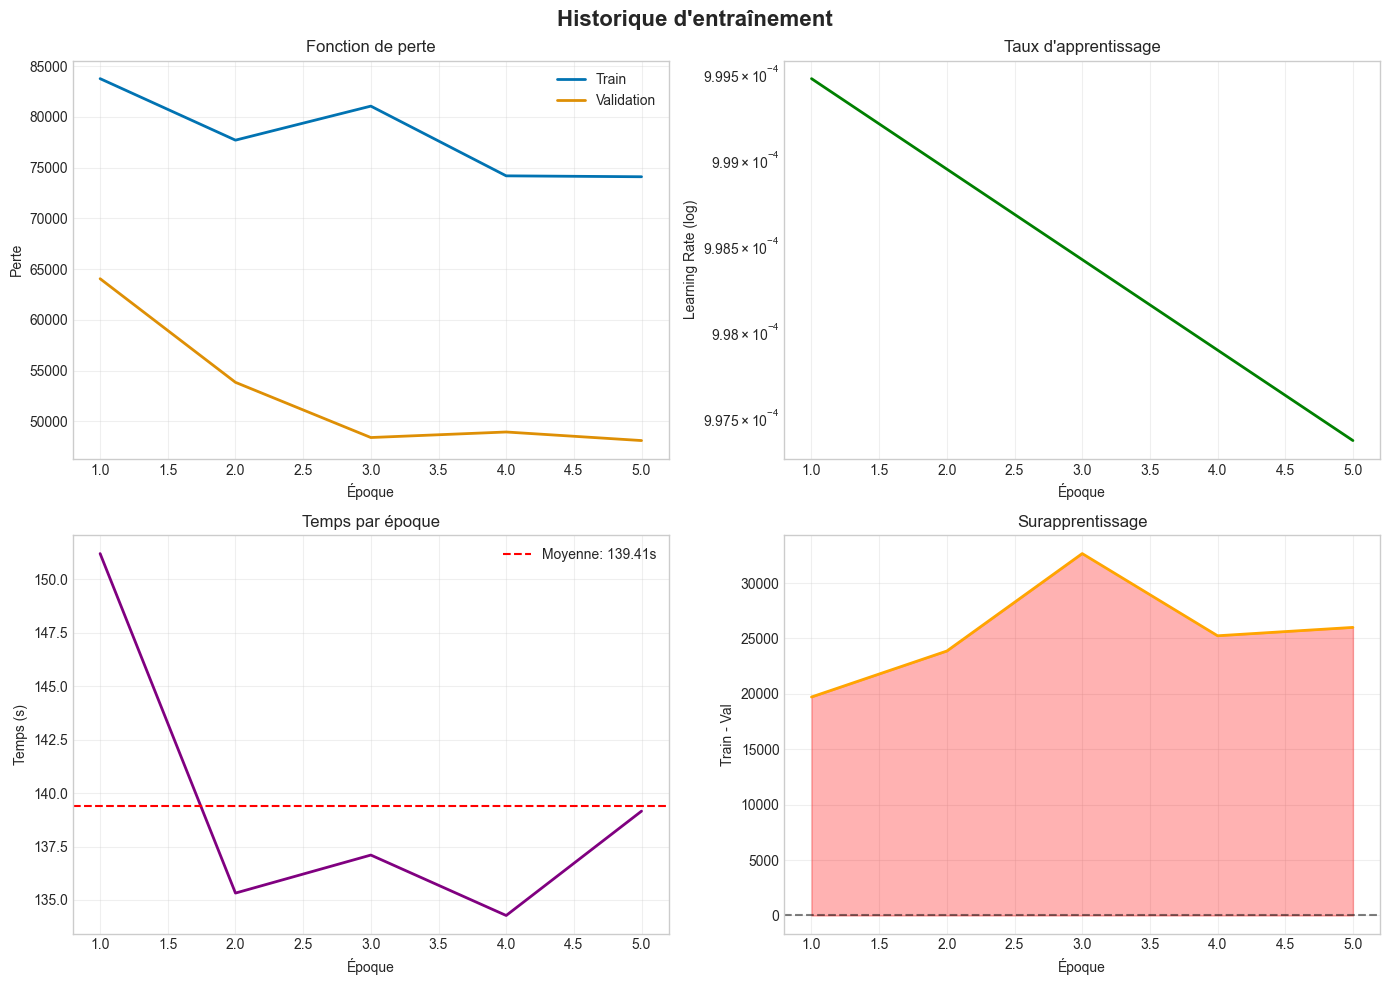

2026-02-03 22:17:58,916 - __main__ - INFO - ✓ Graphique sauvegardé: detailed_results.png


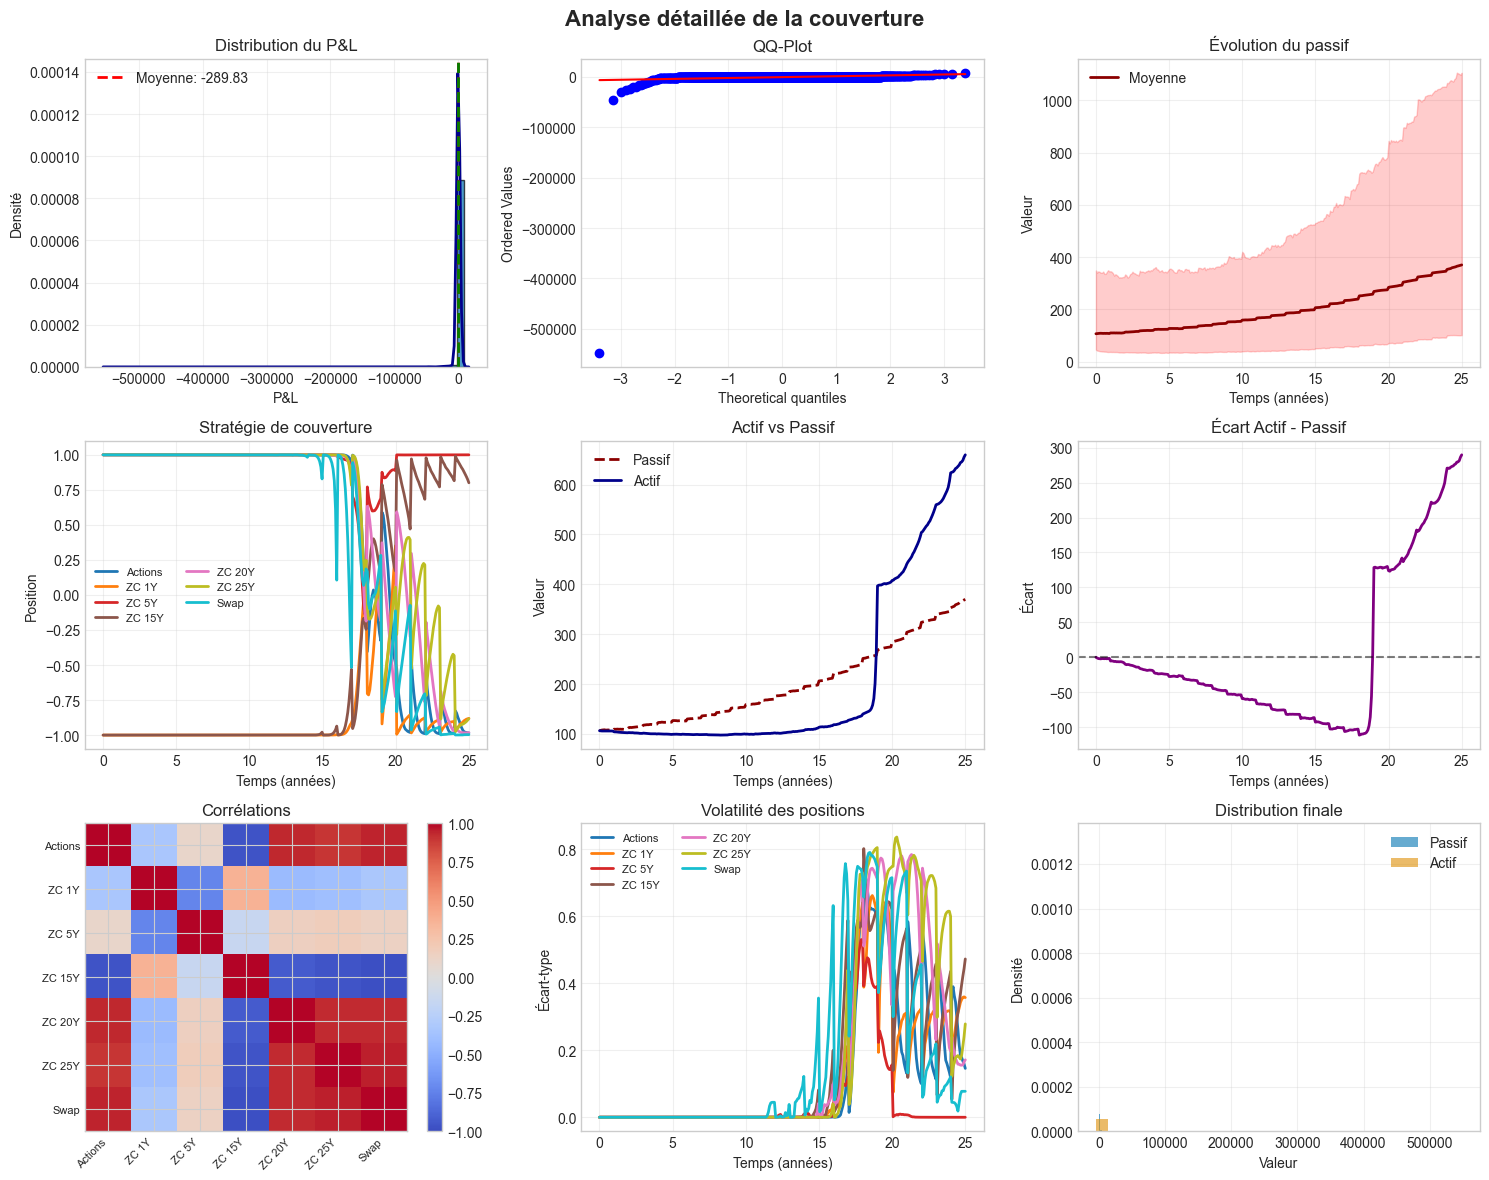

2026-02-03 22:17:59,693 - __main__ - INFO - 💾 Sauvegarde...
2026-02-03 22:17:59,697 - __main__ - INFO - 💾 Sauvegarde du modèle dans saved_model
2026-02-03 22:17:59,815 - __main__ - INFO - ✓ Modèle sauvegardé avec succès
2026-02-03 22:17:59,815 - __main__ - INFO - ================================================================================
2026-02-03 22:17:59,816 - __main__ - INFO - ✅ EXÉCUTION TERMINÉE AVEC SUCCÈS
2026-02-03 22:17:59,817 - __main__ - INFO -    CVaR 99%: 4111.51
2026-02-03 22:17:59,818 - __main__ - INFO -    Efficacité: -1650.11%
2026-02-03 22:17:59,818 - __main__ - INFO - ================================================================================



📊 RÉSULTATS DE PERFORMANCE
╒══════════════╤══════════════╕
│ Métrique     │       Valeur │
╞══════════════╪══════════════╡
│ Mean Pnl     │    -289.83   │
├──────────────┼──────────────┤
│ Std Pnl      │   12392.8    │
├──────────────┼──────────────┤
│ Min Pnl      │ -547819      │
├──────────────┼──────────────┤
│ Max Pnl      │    8588.58   │
├──────────────┼──────────────┤
│ Median Pnl   │     107.102  │
├──────────────┼──────────────┤
│ Var 90       │     361.276  │
├──────────────┼──────────────┤
│ Cvar 90      │    1133.08   │
├──────────────┼──────────────┤
│ Var 95       │     678.687  │
├──────────────┼──────────────┤
│ Cvar 95      │    1792.44   │
├──────────────┼──────────────┤
│ Var 99       │    2619.41   │
├──────────────┼──────────────┤
│ Cvar 99      │    4111.51   │
├──────────────┼──────────────┤
│ Skewness     │     -43.1682 │
├──────────────┼──────────────┤
│ Kurtosis     │    1902.26   │
├──────────────┼──────────────┤
│ Sharpe Ratio │      -0.0234 │
├───────────

In [10]:


# =================================================================================
# SCRIPT PRINCIPAL DE DEEP HEDGING GMAB sans survie ni rachat
# =================================================================================
if __name__ == "__main__":
    logger.info("🚀 Deep Hedging GMAB - Démarrage")
    
    try:
        # Chargement des données
        logger.info("📂 Chargement des données...")
        data = np.load('market_scenarios_final.npz')
        S_paths = data['S_paths'].astype(np.float32)
        L_paths = data['L_paths'].astype(np.float32)
        P_paths = data['P_paths'].astype(np.float32)
        swaps_paths = data['swap_paths'].astype(np.float32)
        logger.info(f"✓ Données chargées: {S_paths.shape[0]} scénarios")
        
        # Paramètres
        N_contracts = 1
        T_years = 25
        N_per_year = 12
        N_max = T_years * N_per_year
        dt_float = 1.0 / N_per_year
        
        # Sélection des ZC
        maturities_to_use = [1, 5, 15, 20, 25]
        indices_zc = [m - 1 for m in maturities_to_use]
        P_selected = P_paths[:, :, indices_zc]
        P_selected = roll_zc_paths(P_selected, maturities_to_use, N_per_year)
        
        # Taux court
        T_grid = np.arange(1, 26)
        r_paths = np.zeros((S_paths.shape[0], N_max + 1), dtype=np.float32)
        for m in range(S_paths.shape[0]):
            for k in range(N_max + 1):
                t = k * dt_float
                beta_idx = np.searchsorted(T_grid, t, side='right')
                if beta_idx < len(T_grid):
                    r_paths[m, k] = np.log(1 + dt_float * L_paths[m, k, beta_idx]) / dt_float
                else:
                    r_paths[m, k] = r_paths[m, k - 1] if k > 0 else 0.02
        
        # Passif GMAB
        Z_paths = np.maximum.accumulate(S_paths, axis=1)
        S_T = S_paths[:, -1:]
        S_T_broadcast = np.tile(S_T, (1, N_max + 1))
        P_Tn = P_paths[:, :, -1]
        L_t = N_contracts * P_Tn * np.maximum(Z_paths, S_T_broadcast)
        H_full = L_t[:, -1].astype(np.float32)
        
        # Préparation des features
        logger.info("🎯 Préparation des features...")
        n_assets = 7 # 1 action + 5 ZC + 1 swap
        n_features = 10
        t_norm = np.linspace(0, 1, N_max + 1, dtype=np.float32)
        
        input_tensor = np.zeros((S_paths.shape[0], N_max + 1, n_features), dtype=np.float32)
        for t in range(N_max + 1):
            input_tensor[:, t, 0] = S_paths[:, t]
            input_tensor[:, t, 1:6] = P_selected[:, t, :]
            input_tensor[:, t, 6] = swaps_paths[:, t]
            input_tensor[:, t, 7] = Z_paths[:, t]
            input_tensor[:, t, 8] = r_paths[:, t]
            input_tensor[:, t, 9] = t_norm[t]
        
        # Log-transformation
        input_tensor[:, :, :6] = np.log(input_tensor[:, :, :6] + 1e-8)
        
        # Split des données
        logger.info("✂️ Division des données...")
        train_size, val_size, test_size = 10000, 2000, 2000
        
        indices = np.arange(S_paths.shape[0])
        np.random.seed(42)
        np.random.shuffle(indices)
        
        train_idx = indices[:train_size]
        val_idx = indices[train_size:train_size + val_size]
        test_idx = indices[train_size + val_size:train_size + val_size + test_size]
        
        train_input = input_tensor[train_idx]
        valid_input = input_tensor[val_idx]
        test_input = input_tensor[test_idx]
        
        H_train = H_full[train_idx]
        H_valid = H_full[val_idx]
        H_test = H_full[test_idx]
        
        r_train = r_paths[train_idx, :-1]
        r_valid = r_paths[val_idx, :-1]
        r_test = r_paths[test_idx, :-1]
        
        L_train = L_t[train_idx]
        L_valid = L_t[val_idx]
        L_test = L_t[test_idx]
        
        # Normalisation
        logger.info("📏 Normalisation...")
        normalizer = DataNormalizer(method='standard')
        train_input_norm = normalizer.fit_transform(train_input)
        valid_input_norm = normalizer.transform(valid_input)
        test_input_norm = normalizer.transform(test_input)
        
        # Configuration
        logger.info("⚙️ Configuration du modèle...")
        config = ModelConfig(
            model_type=ModelType.FFNN,
            n_assets=n_assets,
            n_features=n_features + 1,
            hidden_layers=3,
            units=64,
            learning_rate=0.001,
            alpha_cvar=0.99,
            lambda_cost=0.001,
            scale_factor_zc=1.0,
            dropout_rate=0.3,
            recurrent_dropout=0.2,
            batch_normalization=True
        )
        
        engine = DeepHedgingEngine(config)
        
        V0_train = float(L_train[:, 0].mean())
        V0_valid = float(L_valid[:, 0].mean())
        V0_test = float(L_test[:, 0].mean())
        
        # Entraînement
        history = engine.train(
            train_input=train_input,
            train_input_norm=train_input_norm,
            H_train=H_train,
            r_train=r_train,
            V0_train=V0_train,
            V0_valid=V0_valid,
            dt=dt_float,
            val_input=valid_input,
            val_input_norm=valid_input_norm,
            H_val=H_valid,
            r_val=r_valid,
            epochs=5,
            batch_size=2048,
            patience=10,
            loss_fn=entropic_risk_loss(lam=0.1),
            verbose=1
        )
        
        # Évaluation
        results,V_T, delta_test, V_trajectory,PnL_test = engine.evaluate(
            test_input, test_input_norm, H_test, r_test, dt_float, V0_test
        )



        # Visualisations
        logger.info("🎨 Génération des visualisations...")
        plot_training_history(history, save_path='training_history.png', show=True)
        plot_detailed_results(PnL_test, delta_test, L_test, V_trajectory, 
                            T_years=T_years, save_path='detailed_results.png', show=True)
        print_metrics_table(results)
        
        # Sauvegarde
        logger.info("💾 Sauvegarde...")
        engine.save('saved_model')
        
        logger.info("=" * 80)
        logger.info("✅ EXÉCUTION TERMINÉE AVEC SUCCÈS")
        logger.info(f"   CVaR 99%: {results['cvar_99']:.2f}")
        logger.info(f"   Efficacité: {results['efficiency']:.2%}")
        logger.info("=" * 80)
        
    except FileNotFoundError as e:
        logger.error(f"❌ Fichier non trouvé: {e}")
        sys.exit(1)
    
    except Exception as e:
        logger.error(f"❌ Erreur: {str(e)}", exc_info=True)
        sys.exit(1)
    
    finally:
        tf.keras.backend.clear_session()


In [4]:
CVaR_H_test=cvar_loss(alpha=0.99)(None, tf.expand_dims(H_test, axis=1)).numpy()

In [5]:
print(f"CVaR 99% du passif sur le jeu de test: {CVaR_H_test:}")

CVaR 99% du passif sur le jeu de test: [25090.37]


In [8]:
V_lstm=V_trajectory

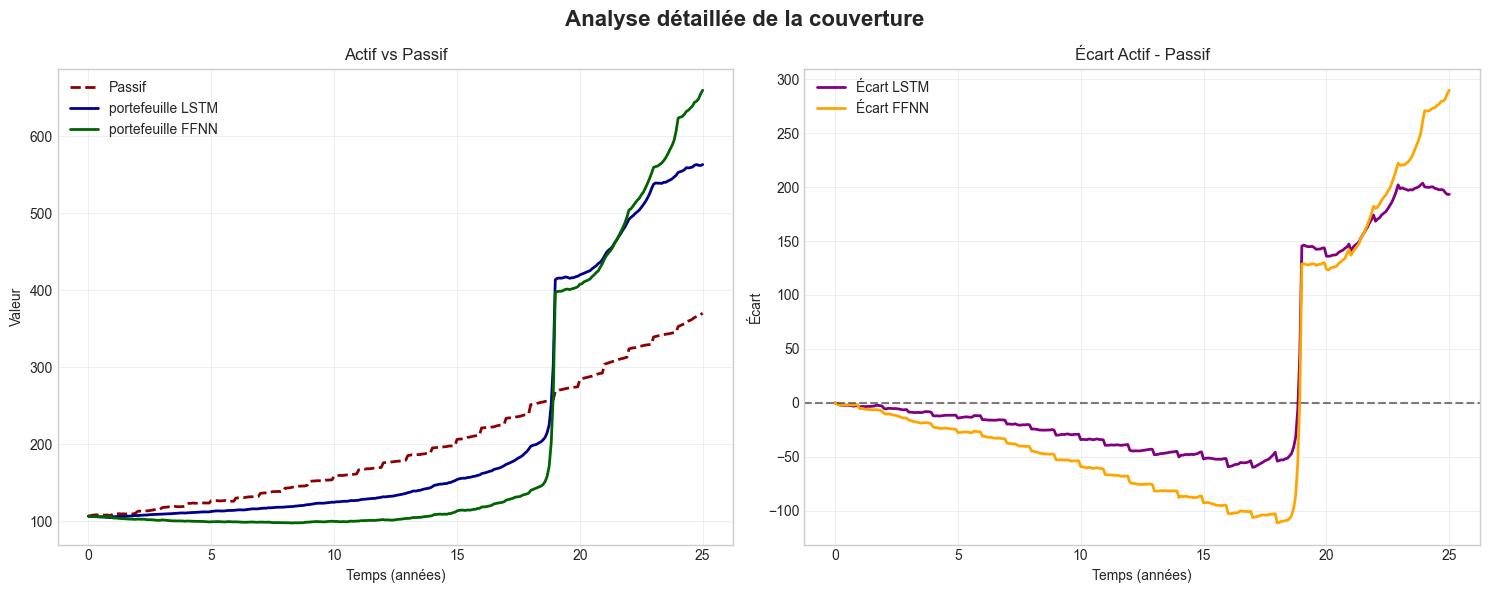

In [14]:
def plot_detailed_result(PnL_test: np.ndarray,
                          L_t: np.ndarray,
                          V_test1: np.ndarray,
                          V_test2: np.ndarray,
                          T_years: float = 25,
                          save_path: Optional[str] = None,
                          show: bool = True) -> None:
    """Visualisations détaillées."""
    plt.style.use('seaborn-v0_8-whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle('Analyse détaillée de la couverture', fontsize=16, fontweight='bold')
    
    t_full = np.linspace(0, T_years, L_t.shape[1] if L_t.ndim == 2 else len(L_t))
    t_hedge = np.linspace(0, T_years, V_test1.shape[1])
    
    # 5. Actif vs Passif
    ax = axes[0]
    if L_t.ndim == 2 and V_test1.ndim == 2:
        L_plot = np.mean(L_t, axis=0)
        V_mean1 = np.mean(V_test1, axis=0)
        V_mean2 = np.mean(V_test2, axis=0)
        ax.plot(t_full, L_plot, color='darkred', linewidth=2, label='Passif', linestyle='--')
        ax.plot(t_full, V_mean1, color='darkblue', linewidth=2, label='portefeuille LSTM')
        ax.plot(t_full, V_mean2, color='darkgreen', linewidth=2, label='portefeuille FFNN')
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Valeur')
    ax.set_title('Actif vs Passif')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 6. Écart
    ax = axes[1]
    if L_t.ndim == 2 and V_test1.ndim == 2:
        diff_1 = V_test1 - L_t
        diff_2 = V_test2 - L_t
        diff_mean_1 = np.mean(diff_1, axis=0)
        diff_mean_2 = np.mean(diff_2, axis=0)
        ax.plot(t_full, diff_mean_1, color='purple', linewidth=2, label='Écart LSTM')
        ax.plot(t_full, diff_mean_2, color='orange', linewidth=2, label='Écart FFNN')
        ax.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Temps (années)')
    ax.set_ylabel('Écart')
    ax.legend()
    ax.set_title('Écart Actif - Passif')
    ax.grid(True, alpha=0.3)

    

    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        logger.info(f"✓ Graphique sauvegardé: {save_path}")
    
    if show:
        plt.show()
    else:
        plt.close()
plot_detailed_result(PnL_test, L_test,  V_lstm, V_trajectory,T_years=T_years, show=True)

SIMULATION DE LA SURVIE ET DES RACHATS

1. Chargement de la table de mortalité...
   Table chargée : âges 40 à 65

2. Calibration du modèle de Makeham...
   Paramètres : a=0.000502, b=0.00008063, c=1.090001

3. Calcul de la courbe de survie...
   Survie à 25 ans : 0.7893

4. Chargement des trajectoires d'actif...
   2000 trajectoires chargées

5. Calcul du facteur de réduction CR_t...
   CR_T moyen = 0.2012 (79.9% de sorties)

6. Analyse des sorties...
   Sorties totales    : 79.88%
   └─ Par décès       : 21.07%
   └─ Par rachats     : 58.82%

7. Génération des graphiques...


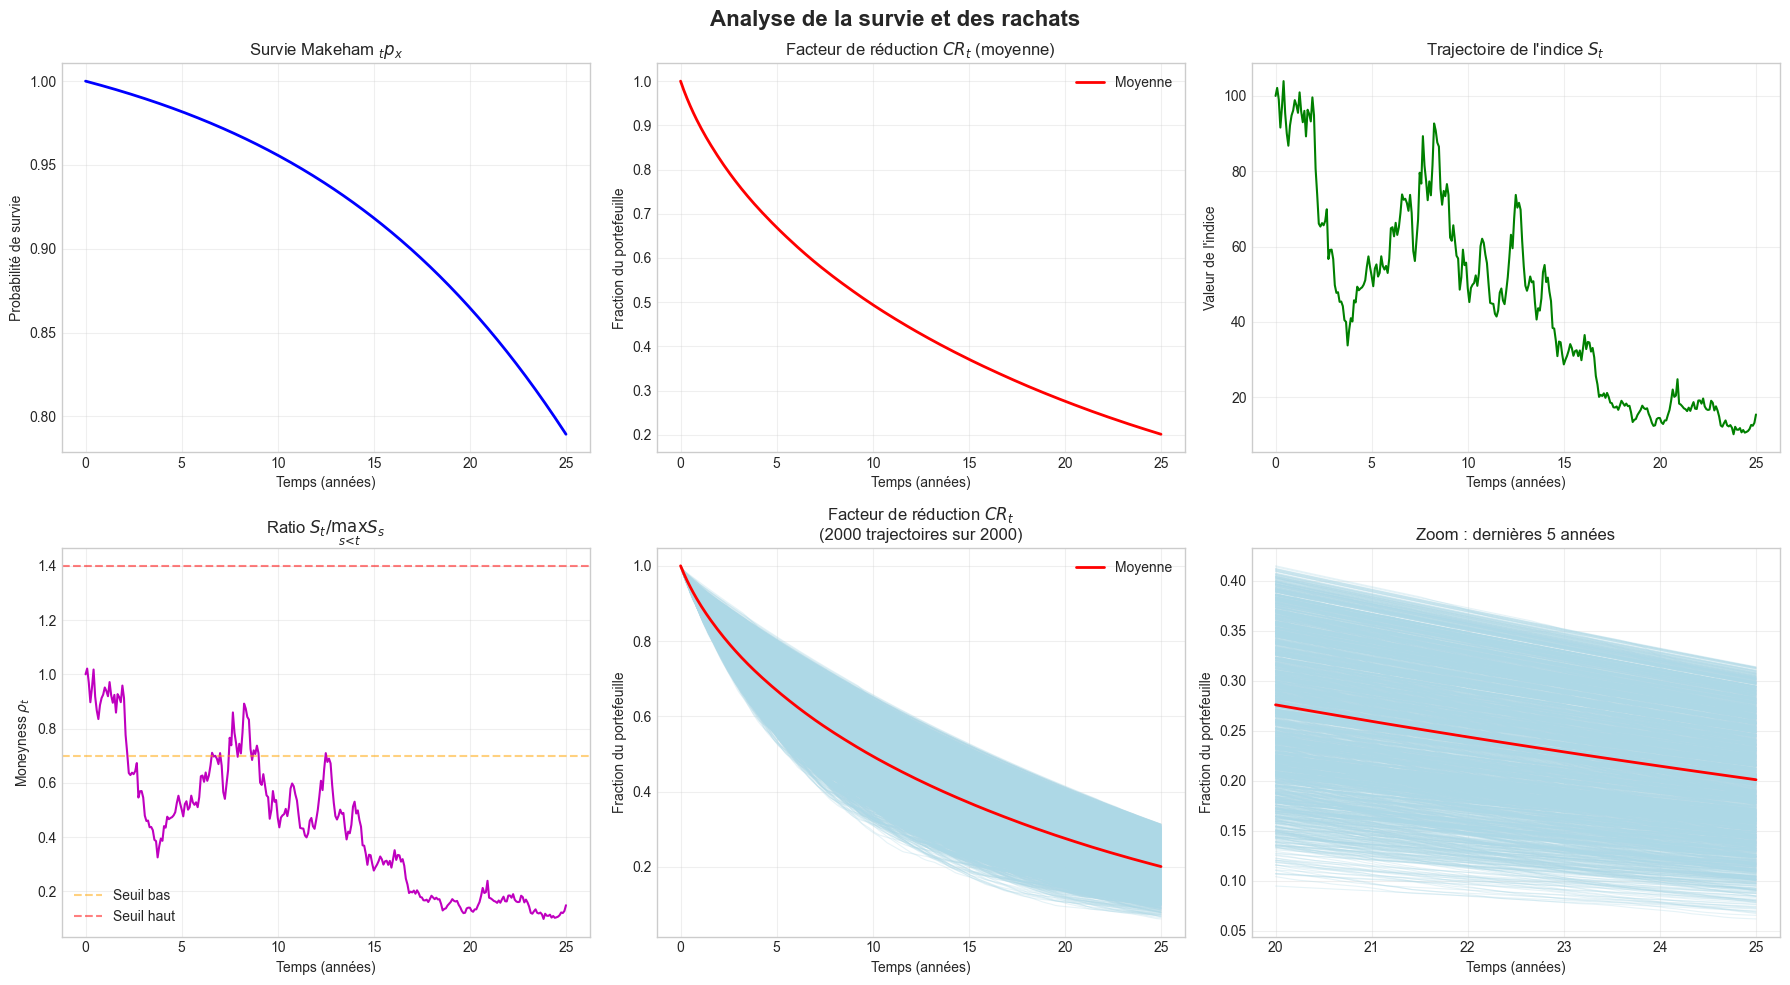


✓ Simulation terminée


In [42]:
# =================================================================================
# SCRIPT PRINCIPAL DE SIMULATION SUR LA SURVIE ET LES RACHATS
# =================================================================================
if __name__ == "__main__":
    print("="*70)
    print("SIMULATION DE LA SURVIE ET DES RACHATS")
    print("="*70)
    
    # 1. Chargement de la table de mortalité
    print("\n1. Chargement de la table de mortalité...")
    TD_raw = pd.read_csv(
        r"C:\DOCUMENTS\Etudes\Uclouvain\MEMOIRE\TD88-90.csv",
        delimiter=";",
        encoding="latin1"
    )
    TD_dict = convertir_table_mortalite_df(TD_raw)
    
    # Extraire qx pour les âges 40 à 65 (inclus)
    ages_calib = np.arange(40, 66)  # 40, 41, ..., 65
    qx_annual = np.array([TD_dict[age] for age in ages_calib], dtype=np.float64)
    print(f"   Table chargée : âges {ages_calib[0]} à {ages_calib[-1]}")
    
    # 2. Calibration de Makeham
    print("\n2. Calibration du modèle de Makeham...")
    a, b, c = calibrate_makeham_annual(qx_annual, ages_calib)  # ← Fonction annuelle
    print(f"   Paramètres : a={a:.6f}, b={b:.8f}, c={c:.6f}")
    
    # 3. Courbe de survie théorique
    print("\n3. Calcul de la courbe de survie...")
    x0 = 40
    T_years = 25
    t_vals = np.linspace(0, T_years, T_years * 12 + 1)
    survival = makeham_survival(t_vals, x0, a, b, c)
    print(f"   Survie à {T_years} ans : {survival[-1]:.4f}")
    
    # 4. Trajectoires d'actif
    print("\n4. Chargement des trajectoires d'actif...")
    S_paths = tf.exp(test_input[:, :, 0]).numpy()  # Convertir en numpy
    N_sim = S_paths.shape[0]
    print(f"   {N_sim} trajectoires chargées")
    
    # 5. Calcul de CR_t
    print("\n5. Calcul du facteur de réduction CR_t...")
    CR_paths = np.zeros_like(S_paths)
    for i in range(N_sim):
        CR_paths[i] = simulate_contract_reduction(
            S_paths[i], x0, a, b, c, surrender_model='piecewise'
        )
    
    CR_mean = np.mean(CR_paths, axis=0)
    print(f"   CR_T moyen = {CR_mean[-1]:.4f} ({100*(1-CR_mean[-1]):.1f}% de sorties)")
    
    # 6. Analyse des sorties
    print("\n6. Analyse des sorties...")
    theoretical_survival = makeham_survival(T_years, x0, a, b, c)
    total_exit = 1 - CR_mean[-1]
    death_exit = 1 - theoretical_survival
    surrender_exit = total_exit - death_exit
    
    print(f"   Sorties totales    : {100*total_exit:.2f}%")
    print(f"   └─ Par décès       : {100*death_exit:.2f}%")
    print(f"   └─ Par rachats     : {100*surrender_exit:.2f}%")
    
    # 7. Visualisation
    print("\n7. Génération des graphiques...")
    plot_survival_and_cr(t_vals, survival, CR_paths, S_paths)
    
    print("\n" + "="*70)
    print("✓ Simulation terminée")
    print("="*70)

2026-02-03 17:17:54,542 - __main__ - INFO - 🚀 Deep Hedging GMAB - Démarrage
2026-02-03 17:17:54,544 - __main__ - INFO - 📂 Chargement des données...
2026-02-03 17:18:10,323 - __main__ - INFO - ✓ Données chargées: 50000 scénarios



5. Calcul du facteur de réduction CR_t...


2026-02-03 17:20:01,078 - __main__ - INFO - 🎯 Préparation des features...
2026-02-03 17:20:03,862 - __main__ - INFO - ✂️ Division des données...
2026-02-03 17:20:03,947 - __main__ - INFO - 📏 Normalisation...
2026-02-03 17:20:04,145 - __main__ - INFO - Normalizer fitted - method: standard
2026-02-03 17:20:04,296 - __main__ - INFO - ⚙️ Configuration du modèle...
2026-02-03 17:20:04,322 - __main__ - INFO - ✓ DeepHedgingEngine initialisé - LSTM
2026-02-03 17:20:04,443 - __main__ - INFO - ================================================================================
2026-02-03 17:20:04,443 - __main__ - INFO - 🚀 DÉBUT DE L'ENTRAÎNEMENT
2026-02-03 17:20:04,443 - __main__ - INFO - ================================================================================
2026-02-03 17:20:04,443 - __main__ - INFO - 🔨 Construction du modèle LSTM
2026-02-03 17:20:04,931 - __main__ - INFO - ✓ Modèle construit - Paramètres: 9,255
2026-02-03 17:20:04,943 - __main__ - INFO - ✓ Modèle compilé
2026-02-03 17:20:

300


2026-02-03 17:55:32,719 - __main__ - INFO - ✓ Prédictions générées
2026-02-03 17:55:32,762 - __main__ - INFO - 
2026-02-03 17:55:32,762 - __main__ - INFO - 📈 RÉSULTATS D'ÉVALUATION
2026-02-03 17:55:32,766 - __main__ - INFO - ================================================================================
2026-02-03 17:55:32,766 - __main__ - INFO -   mean_pnl......................       -676.9979
2026-02-03 17:55:32,766 - __main__ - INFO -   std_pnl.......................      15103.1934
2026-02-03 17:55:32,766 - __main__ - INFO -   min_pnl.......................    -670094.3125
2026-02-03 17:55:32,766 - __main__ - INFO -   max_pnl.......................        382.7383
2026-02-03 17:55:32,766 - __main__ - INFO -   median_pnl....................        -57.3314
2026-02-03 17:55:32,774 - __main__ - INFO -   var_90........................         52.8825
2026-02-03 17:55:32,775 - __main__ - INFO -   cvar_90.......................         73.4785
2026-02-03 17:55:32,775 - __main__ - INFO -

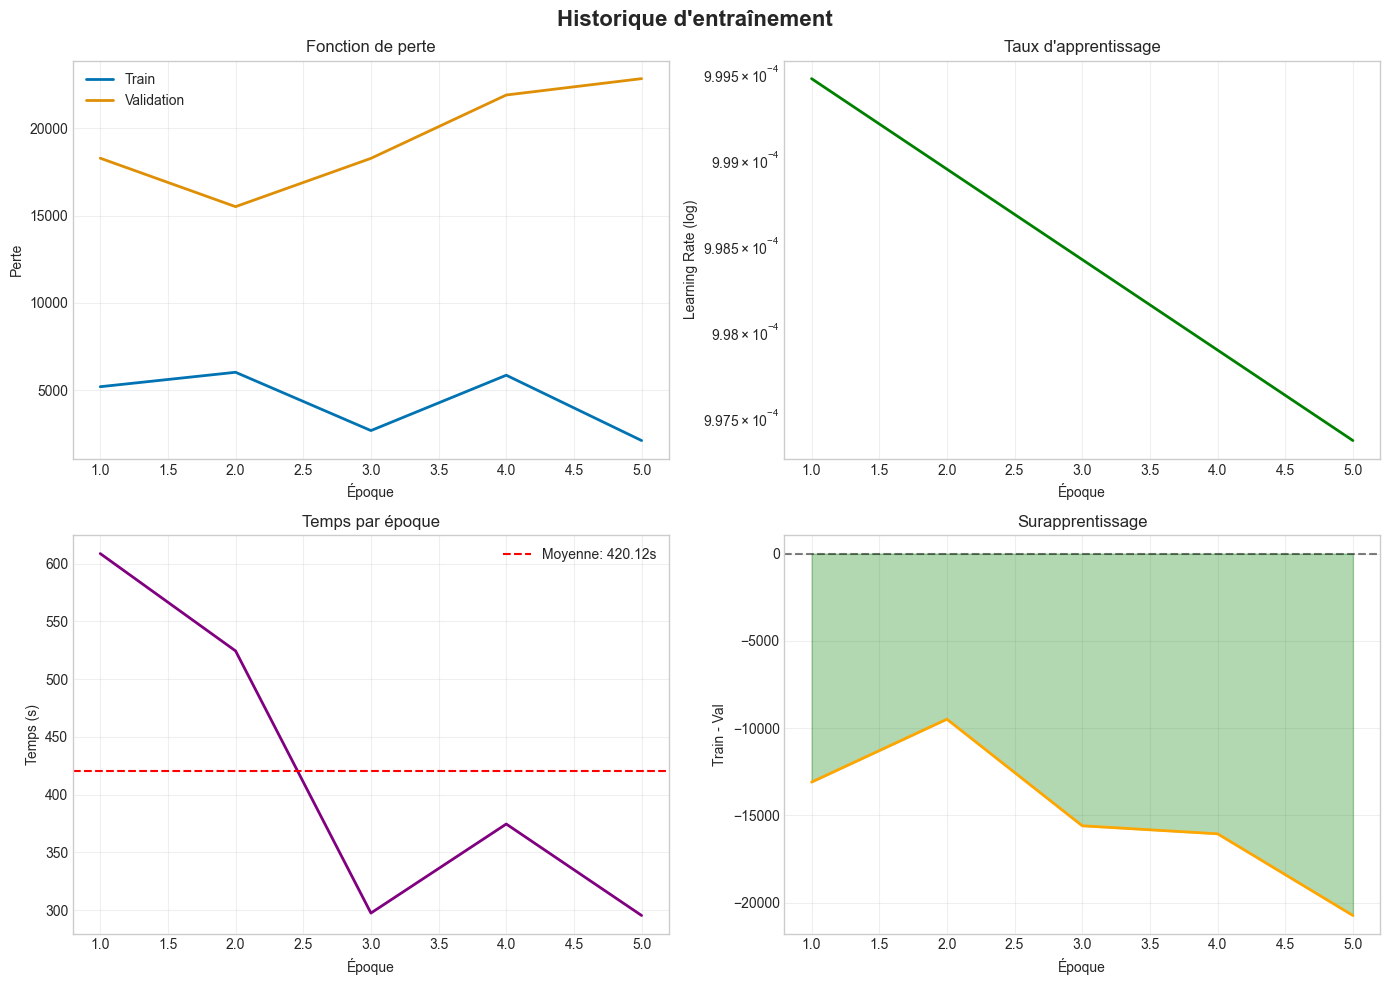

2026-02-03 17:55:36,451 - __main__ - INFO - ✓ Graphique sauvegardé: detailed_results.png


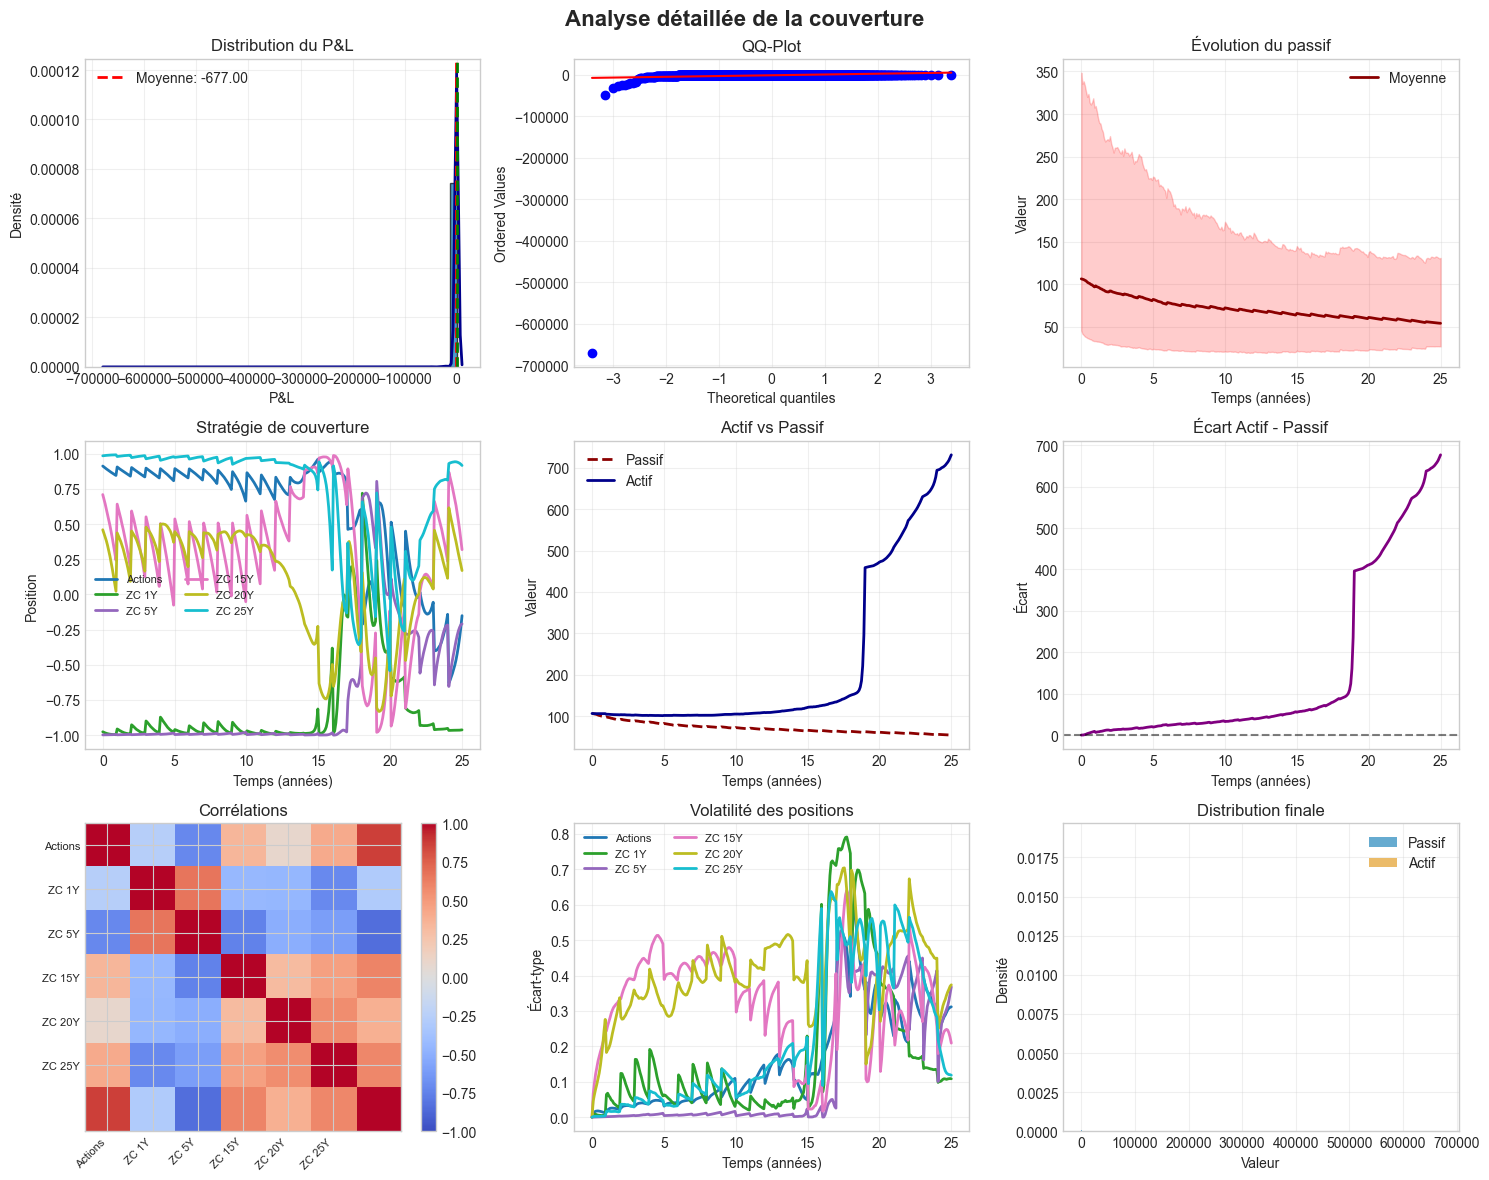

2026-02-03 17:55:37,237 - __main__ - INFO - 💾 Sauvegarde...
2026-02-03 17:55:37,237 - __main__ - INFO - 💾 Sauvegarde du modèle dans saved_model
2026-02-03 17:55:37,403 - __main__ - INFO - ✓ Modèle sauvegardé avec succès
2026-02-03 17:55:37,403 - __main__ - INFO - ================================================================================
2026-02-03 17:55:37,403 - __main__ - INFO - ✅ EXÉCUTION TERMINÉE AVEC SUCCÈS
2026-02-03 17:55:37,409 - __main__ - INFO -    CVaR 99%: 136.75
2026-02-03 17:55:37,410 - __main__ - INFO -    Efficacité: -27958.91%
2026-02-03 17:55:37,410 - __main__ - INFO - ================================================================================



📊 RÉSULTATS DE PERFORMANCE
╒══════════════╤══════════════╕
│ Métrique     │       Valeur │
╞══════════════╪══════════════╡
│ Mean Pnl     │    -676.998  │
├──────────────┼──────────────┤
│ Std Pnl      │   15103.2    │
├──────────────┼──────────────┤
│ Min Pnl      │ -670094      │
├──────────────┼──────────────┤
│ Max Pnl      │     382.738  │
├──────────────┼──────────────┤
│ Median Pnl   │     -57.3314 │
├──────────────┼──────────────┤
│ Var 90       │      52.8825 │
├──────────────┼──────────────┤
│ Cvar 90      │      73.4785 │
├──────────────┼──────────────┤
│ Var 95       │      66.0809 │
├──────────────┼──────────────┤
│ Cvar 95      │      87.1199 │
├──────────────┼──────────────┤
│ Var 99       │      88.3261 │
├──────────────┼──────────────┤
│ Cvar 99      │     136.755  │
├──────────────┼──────────────┤
│ Skewness     │     -43.569  │
├──────────────┼──────────────┤
│ Kurtosis     │    1926.75   │
├──────────────┼──────────────┤
│ Sharpe Ratio │      -0.0448 │
├───────────

In [43]:


# =================================================================================
# SCRIPT PRINCIPAL DE DEEP HEDGING GMAB avec survie et rachat
# =================================================================================
if __name__ == "__main__":
    logger.info("🚀 Deep Hedging GMAB - Démarrage")
    
    try:
        # Chargement des données
        logger.info("📂 Chargement des données...")
        data = np.load('market_scenarios_final.npz')
        S_paths = data['S_paths'].astype(np.float32)
        L_paths = data['L_paths'].astype(np.float32)
        P_paths = data['P_paths'].astype(np.float32)
        swaps_paths = data['swap_paths'].astype(np.float32)
        logger.info(f"✓ Données chargées: {S_paths.shape[0]} scénarios")
        
        # Paramètres
        N_contracts = 1
        T_years = 25
        N_per_year = 12
        N_max = T_years * N_per_year
        dt_float = 1.0 / N_per_year
        
        # Sélection des ZC
        maturities_to_use = [1, 5, 15, 20, 25]
        indices_zc = [m - 1 for m in maturities_to_use]
        P_selected = P_paths[:, :, indices_zc]
        P_selected = roll_zc_paths(P_selected, maturities_to_use, N_per_year)
        
        # Taux court
        T_grid = np.arange(1, 26)
        r_paths = np.zeros((S_paths.shape[0], N_max + 1), dtype=np.float32)
        for m in range(S_paths.shape[0]):
            for k in range(N_max + 1):
                t = k * dt_float
                beta_idx = np.searchsorted(T_grid, t, side='right')
                if beta_idx < len(T_grid):
                    r_paths[m, k] = np.log(1 + dt_float * L_paths[m, k, beta_idx]) / dt_float
                else:
                    r_paths[m, k] = r_paths[m, k - 1] if k > 0 else 0.02
        # =================================================================================
        # Modélisation de la survie et des rachats
        # =================================================================================
        #  Calcul de CR_t
        a, b, c = 0.000502, 0.00008063, 1.090001
        x0 = 40  # Âge initial
        N_sim = S_paths.shape[0]
        print("\n5. Calcul du facteur de réduction CR_t...")
        CR_paths = np.zeros_like(S_paths)
        for i in range(N_sim):
            CR_paths[i] = simulate_contract_reduction(
                S_paths[i], x0, a, b, c, surrender_model='piecewise'
            )
        #=========================================================================================
        # Passif GMAB
        Z_paths = np.maximum.accumulate(S_paths, axis=1)
        S_T = S_paths[:, -1:]
        S_T_broadcast = np.tile(S_T, (1, N_max + 1))
        P_Tn = P_paths[:, :, -1]
        L_t = N_contracts *CR_paths* P_Tn * np.maximum(Z_paths, S_T_broadcast)
        H_full = L_t[:, -1].astype(np.float32)
        
        # Préparation des features
        logger.info("🎯 Préparation des features...")
        n_assets = 7 # 1 action + 5 ZC + 1 swap
        n_features = 11
        t_norm = np.linspace(0, 1, N_max + 1, dtype=np.float32)
        
        input_tensor = np.zeros((S_paths.shape[0], N_max + 1, n_features), dtype=np.float32)
        for t in range(N_max + 1):
            input_tensor[:, t, 0] = S_paths[:, t]
            input_tensor[:, t, 1:6] = P_selected[:, t, :]
            input_tensor[:, t, 6] = swaps_paths[:, t]
            input_tensor[:, t, 7] = Z_paths[:, t]
            input_tensor[:, t, 8] = r_paths[:, t]
            input_tensor[:, t, 9] = CR_paths[:, t]
            input_tensor[:, t, 10] = t_norm[t]
        
        # Log-transformation
        input_tensor[:, :, :6] = np.log(input_tensor[:, :, :6] + 1e-8)
        
        # Split des données
        logger.info("✂️ Division des données...")
        train_size, val_size, test_size = 10000, 2000, 2000
        
        indices = np.arange(S_paths.shape[0])
        np.random.seed(42)
        np.random.shuffle(indices)
        
        train_idx = indices[:train_size]
        val_idx = indices[train_size:train_size + val_size]
        test_idx = indices[train_size + val_size:train_size + val_size + test_size]
        
        train_input = input_tensor[train_idx]
        valid_input = input_tensor[val_idx]
        test_input = input_tensor[test_idx]
        
        H_train = H_full[train_idx]
        H_valid = H_full[val_idx]
        H_test = H_full[test_idx]
        
        r_train = r_paths[train_idx, :-1]
        r_valid = r_paths[val_idx, :-1]
        r_test = r_paths[test_idx, :-1]
        
        L_train = L_t[train_idx]
        L_valid = L_t[val_idx]
        L_test = L_t[test_idx]
        
        # Normalisation
        logger.info("📏 Normalisation...")
        normalizer = DataNormalizer(method='standard')
        train_input_norm = normalizer.fit_transform(train_input)
        valid_input_norm = normalizer.transform(valid_input)
        test_input_norm = normalizer.transform(test_input)
        
        # Configuration
        logger.info("⚙️ Configuration du modèle...")
        config = ModelConfig(
            model_type=ModelType.LSTM,
            n_assets=n_assets,
            n_features=n_features + 1,
            hidden_layers=2,
            units=32,
            learning_rate=0.001,
            alpha_cvar=0.99,
            lambda_cost=0.001,
            scale_factor_zc=1.0,
            dropout_rate=0.3,
            recurrent_dropout=0.2,
            batch_normalization=True
        )
        
        engine = DeepHedgingEngine(config)
        
        V0_train = float(L_train[:, 0].mean())
        V0_valid = float(L_valid[:, 0].mean())
        V0_test = float(L_test[:, 0].mean())
        
        # Entraînement
        history = engine.train(
            train_input=train_input,
            train_input_norm=train_input_norm,
            H_train=H_train,
            r_train=r_train,
            V0_train=V0_train,
            V0_valid=V0_valid,
            dt=dt_float,
            val_input=valid_input,
            val_input_norm=valid_input_norm,
            H_val=H_valid,
            r_val=r_valid,
            epochs=5,
            batch_size=2048,
            patience=10,
            loss_fn=cvar_loss(alpha=0.99),
            verbose=1
        )
        
        # Évaluation
        results,V_T, delta_test, V_trajectory,PnL_test = engine.evaluate(
            test_input, test_input_norm, H_test, r_test, dt_float, V0_test
        )
        
        """
        # Prédictions détaillées
        V_T, delta_test, V_trajectory = engine.predict(
            test_input, test_input_norm, r_test, dt_float, V0_test, return_trajectory=True
        )
        
        PnL_test = H_test - V_T

        """



        # Visualisations
        logger.info("🎨 Génération des visualisations...")
        plot_training_history(history, save_path='training_history.png', show=True)
        plot_detailed_results(PnL_test, delta_test, L_test, V_trajectory, 
                            T_years=T_years, save_path='detailed_results.png', show=True)
        print_metrics_table(results)
        
        # Sauvegarde
        logger.info("💾 Sauvegarde...")
        engine.save('saved_model')
        
        logger.info("=" * 80)
        logger.info("✅ EXÉCUTION TERMINÉE AVEC SUCCÈS")
        logger.info(f"   CVaR 99%: {results['cvar_99']:.2f}")
        logger.info(f"   Efficacité: {results['efficiency']:.2%}")
        logger.info("=" * 80)
        
    except FileNotFoundError as e:
        logger.error(f"❌ Fichier non trouvé: {e}")
        sys.exit(1)
    
    except Exception as e:
        logger.error(f"❌ Erreur: {str(e)}", exc_info=True)
        sys.exit(1)
    
    finally:
        tf.keras.backend.clear_session()


In [44]:
CVaR_H_test=cvar_loss(alpha=0.99)(None, tf.expand_dims(H_test, axis=1)).numpy()

In [45]:
CVaR_H_test

array([2031.1061], dtype=float32)